# Homework 04: Building CNNs for Image Classification

## Due: Midnight on September 28 (with 2-hour grace period) and worth 85 points

In this assignment, you will take your first steps into designing and training convolutional neural networks (CNNs) for image classification. Starting from a simple baseline, you will experiment with modifications that reflect the kinds of design choices practitioners face every day. Along the way, you’ll see how architecture, hyperparameters, normalization, pooling strategies, and learning rate schedules can each shape a model’s performance.

The problems are organized to build on each other:

1. **Hyperparameters:** Begin with a baseline CNN and try variations in learning rate, layer width, depth, and dropout.
2. **Batch Normalization:** Add normalization after convolutional layers to stabilize training and speed convergence.
3. **Global Average Pooling:** Replace the flatten-and-dense head with a modern pooling layer, reducing parameters and improving generalization.
4. **ReduceLROnPlateau:** Explore a widely used learning rate scheduler that adapts when validation progress slows.
5. **Very Deep CNN:** Finally, run a VGG-16–style model to observe how deeper networks behave compared to smaller ones.

By the end of this homework, you will have hands-on experience with both classical and modern CNN design strategies, a sense of how different components affect learning, and a toolkit of techniques that will serve you in future image processing projects.

There are 10 graded questions, worth 8 points each, with 5 points free if you complete the homework.


## 1. Setup and Data Loading


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os,time,random,kagglehub

import tensorflow as tf
from tensorflow.keras import layers, Input, models, callbacks, regularizers,initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,MaxPooling2D,Conv2D,SeparableConv2D,GlobalAveragePooling2D,GlobalMaxPooling2D,BatchNormalization

from sklearn.model_selection import train_test_split

# utility code

# -------------------------
# Reproducibility settings
# -------------------------

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [ ]:

def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(),
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- `X_train,y_train,X_val,y_val,X_test,y_test` already defined, accessed here as global variables

In [ ]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model,
                   epochs        = 500,                   # Just needs to be bigger than early stopping point
                   lr_schedule   = 1e-3,                  # Adam default
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 128,
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer

    #Compiling the model
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )


    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()

    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]

    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")

    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the Intel Image Classification Dataset  



In [ ]:
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

Using Colab cache for faster access to the 'intel-image-classification' dataset.


In [ ]:
# Reproducible load + preprocess for Intel Image Classification

# -------------------------
# Loader (deterministic)
# -------------------------
def load_data_from_directory(directory, img_size=(150, 150), class_names=None):
    """
    Loads images as float32 in [0,1] and integer labels.
    Sorting ensures deterministic order. If class_names is provided,
    that ordering defines label indices.
    Returns: X, y, class_names_used
    """
    if class_names is None:
        class_names = sorted(
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
        )
    else:
        # Ensure only classes present in directory are used (robustness)
        class_names = [c for c in class_names if os.path.isdir(os.path.join(directory, c))]

    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    X, y = [], []
    for class_name in class_names:
        folder = os.path.join(directory, class_name)
        # Sort filenames so load order is reproducible
        for fname in sorted(os.listdir(folder)):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            img_path = os.path.join(folder, fname)
            # Explicit interpolation for consistency
            img = load_img(img_path, target_size=img_size, interpolation="bilinear")
            arr = img_to_array(img)  # float32
            X.append(arr)
            y.append(class_to_idx[class_name])

    X = (np.array(X, dtype="float32") / 255.0)   # normalize to [0,1]
    y = np.array(y, dtype="int32")               # integer labels
    return X, y, class_names

def show_counts(name, y_arr):
    c = Counter(y_arr.tolist() if hasattr(y_arr, "tolist") else y_arr)
    print(f"{name} per-class counts:", dict(c))

# -------------------------
# Download & paths
# -------------------------
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

# -------------------------
# Load train (get class_names) & test using same mapping
# -------------------------
X_train_all, y_train_all, class_names = load_data_from_directory(train_dir, img_size=(150,150))
X_test,       y_test,   _            = load_data_from_directory(test_dir, img_size=(150,150), class_names=class_names)

num_classes = len(class_names)
print("class_names:", class_names)
print("X_train_all:", X_train_all.shape, "y_train_all:", y_train_all.shape)
print("X_test:     ", X_test.shape,      "y_test:     ", y_test.shape)

# -------------------------
# Stratified train/val split (reproducible)
# -------------------------

X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all,
    test_size=0.2,
    stratify=y_train_all,
    random_state=random_seed,
    shuffle=True
)

Using Colab cache for faster access to the 'intel-image-classification' dataset.
class_names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
X_train_all: (14034, 150, 150, 3) y_train_all: (14034,)
X_test:      (3000, 150, 150, 3) y_test:      (3000,)


### Examine The Dataset

In [ ]:
print("X_train:",  X_train.shape,  "y_train:",  y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

X_train: (11227, 150, 150, 3) y_train: (11227,)
X_val: (2807, 150, 150, 3) y_val: (2807,)
train per-class counts: {0: 1753, 4: 1819, 2: 1923, 1: 1817, 5: 1906, 3: 2009}
val   per-class counts: {1: 454, 2: 481, 3: 503, 0: 438, 4: 455, 5: 476}
test  per-class counts: {0: 437, 1: 474, 2: 553, 3: 525, 4: 510, 5: 501}


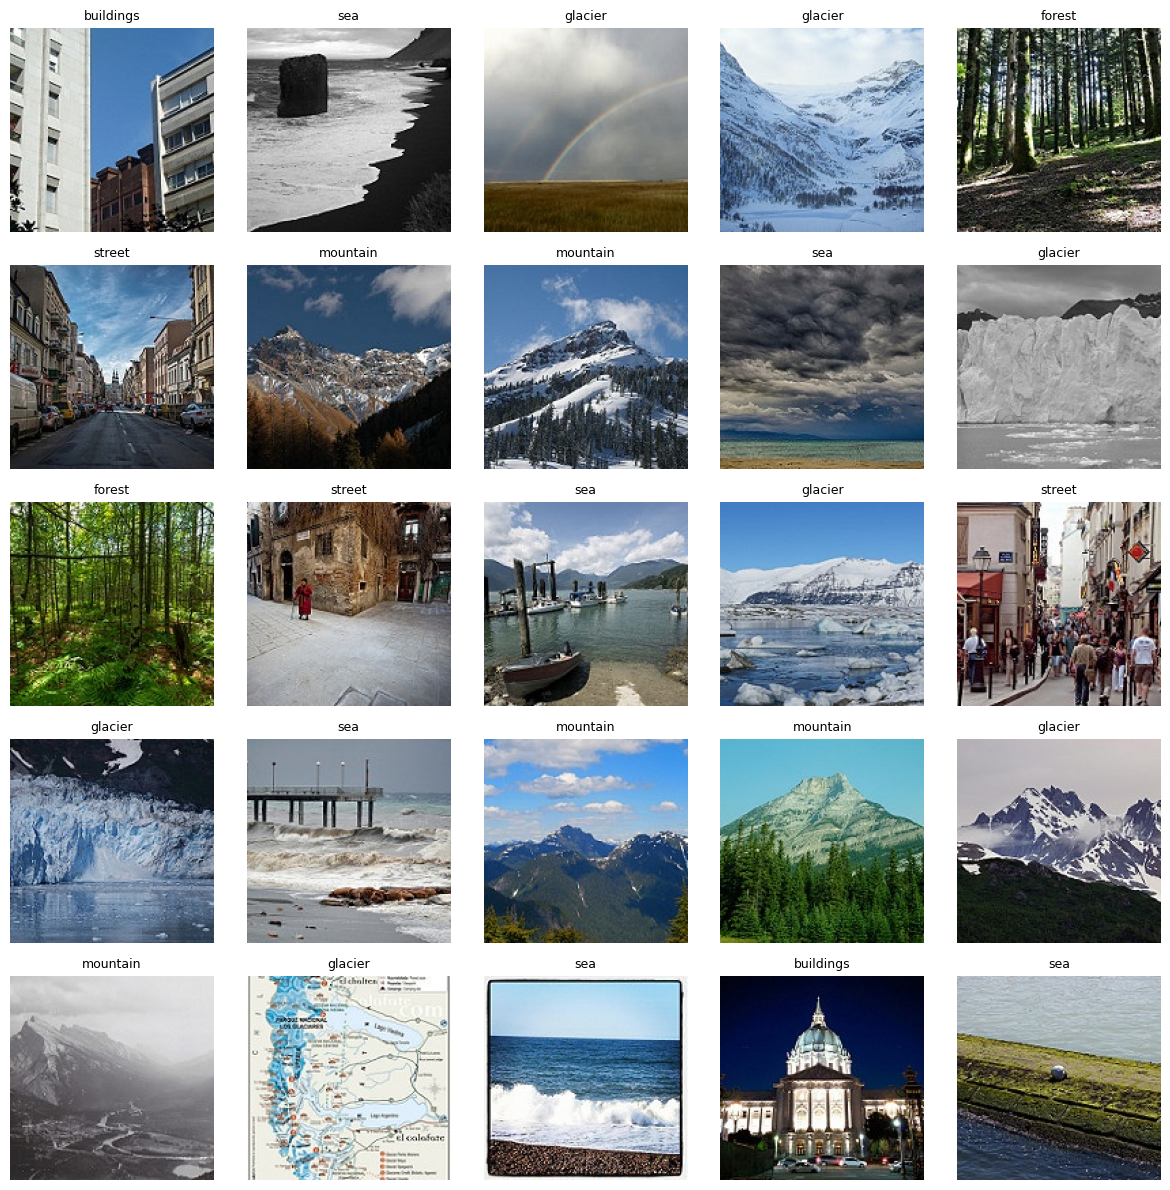

In [ ]:
# Show a 5×5 grid of the first 25 training images
plt.figure(figsize=(12, 12))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    # X_train is already a NumPy array [0–1], so no .numpy() needed
    plt.imshow(X_train[i])
    # pick the class name from your class_names list
    plt.title(class_names[y_train[i]], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Prelude: Baseline CNN (reference model)

This is our **reference** network: two Conv→Pool blocks with channels **32 → 64**, followed by a **single hidden head** `Dense(64)`. We use **He** initialization for ReLU activations and include an **optional `Dropout(0.5)`** to illustrate regularization—comment it out to gauge its impact (ha, not really optional!).

Use this model as a stable yardstick while you run **ablations**: change **one knob at a time** (e.g., widen/deepen the conv blocks, adjust dropout rate, add batch norm, tweak the LR schedule) and compare results back to this baseline. Focus on **training vs. validation curves**, the **generalization gap**, and how dropout affects **val loss/accuracy** and how long it takes for Early Stopping to kick in.



Baseline Model



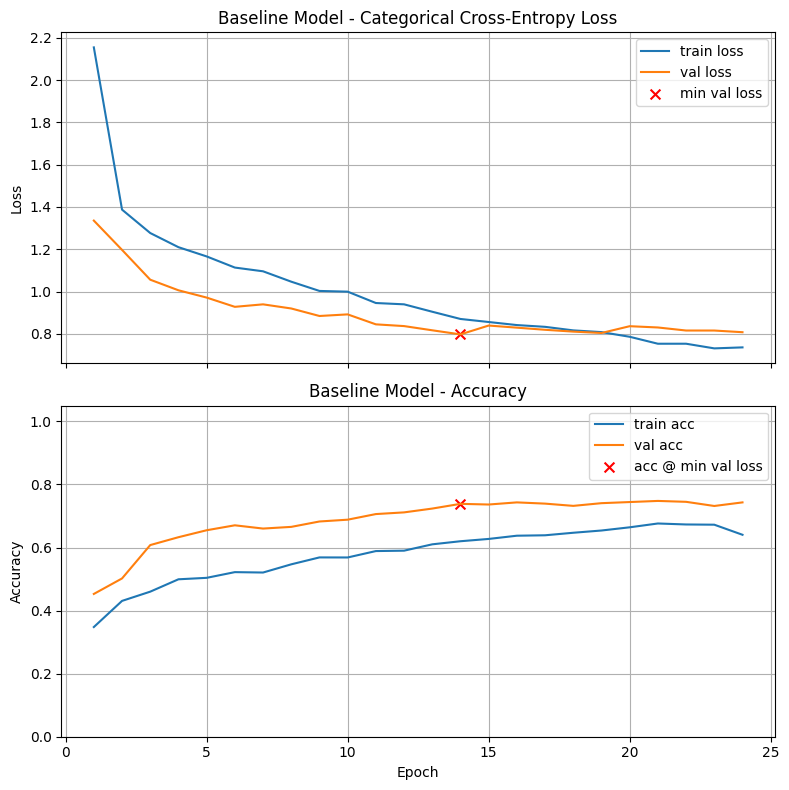

Final Training Loss:            0.7358
Final Training Accuracy:        0.6404
Final Validation Loss:          0.8076
Final Validation Accuracy:      0.7431
Minimum Validation Loss:        0.7972 (Epoch 14)
Validation Accuracy @ Min Loss: 0.7385

Test Loss: 0.8050
Test Accuracy: 0.7243

Validation-Test Gap (accuracy): 0.014178

Execution Time: 00:01:13


In [ ]:
he = initializers.HeNormal()                                # best initializer for relu

model_baseline= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_baseline,title="Baseline Model")


## Problem One: Exploring Basic Hyperparameters

**Task:**
Copy the baseline CNN model into the next cell and experiment with basic hyperparameter changes. Your goal is to see whether small tweaks can improve validation accuracy (and hopefully speed up convergence or produce smoother training curves). You must **pick 3 of the following tweaks** and investigate their effect:

**Tweaks to Try:**

1. Adjust the learning rate (default for Adam is `1e-3`).
2. Change the width of the `Conv2D` layers (e.g., 64 → 128).
3. Add an extra `Conv2D` layer (e.g., stack 32 → 64 → 128).
4. Change the width of the `Dense(64 ...)` layer.
5. Add L2 regularization to the `Dense(64 ...)` layer (see the head of the network in Problem 5 for inspiration).  
6. Modify the dropout rate.
   
Observe the effect of each of your 3 choices in isolation and answer the graded questions.

**Optional:**
Combine two or more changes to see if they work together to improve results (example: try L2 regularization and reduced dropout in the head, as in Problem 5).


**Pro Tip:** Give each experiment a descriptive title, such as "Problem 1 -- Tweak 1 -- lr: 0.0005" to keep track of your experiments (see last cell in the notebook).


Problem 1 -- Tweak 1.1 -- lr: 1e-4



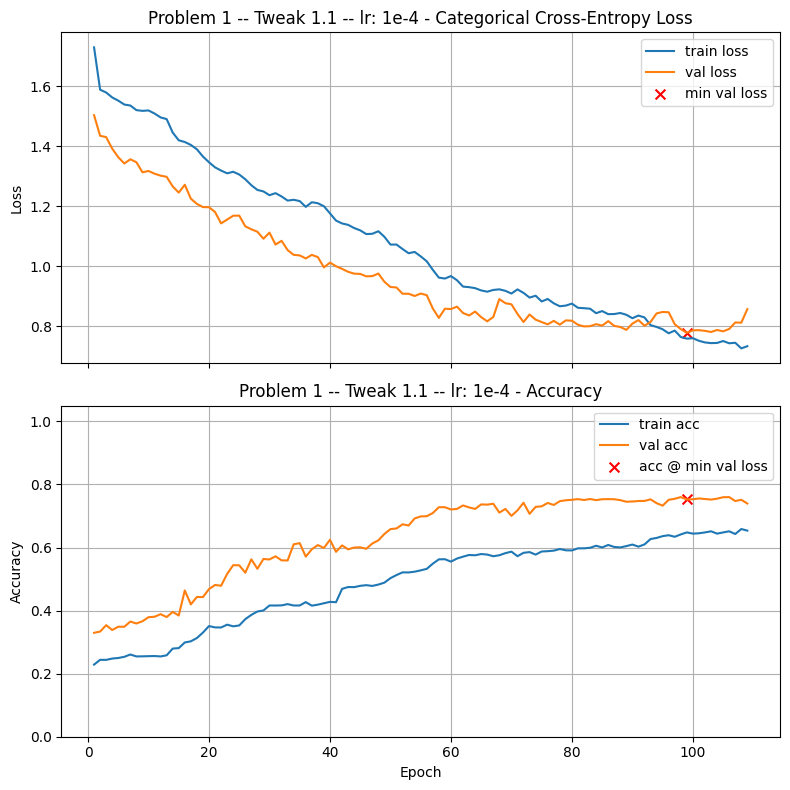

Final Training Loss:            0.7331
Final Training Accuracy:        0.6536
Final Validation Loss:          0.8566
Final Validation Accuracy:      0.7396
Minimum Validation Loss:        0.7777 (Epoch 99)
Validation Accuracy @ Min Loss: 0.7524

Test Loss: 0.7680
Test Accuracy: 0.7580

Validation-Test Gap (accuracy): 0.005595

Execution Time: 00:04:00


In [ ]:
# Your code here, add additional cells if you wish

# Adjusting learning rate

he = initializers.HeNormal()                                # best initializer for relu

model_lr1= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_lr1, lr_schedule=1e-4, title="Problem 1 -- Tweak 1.1 -- lr: 1e-4")


Problem 1 -- Tweak 1.2 -- lr: 1e-5



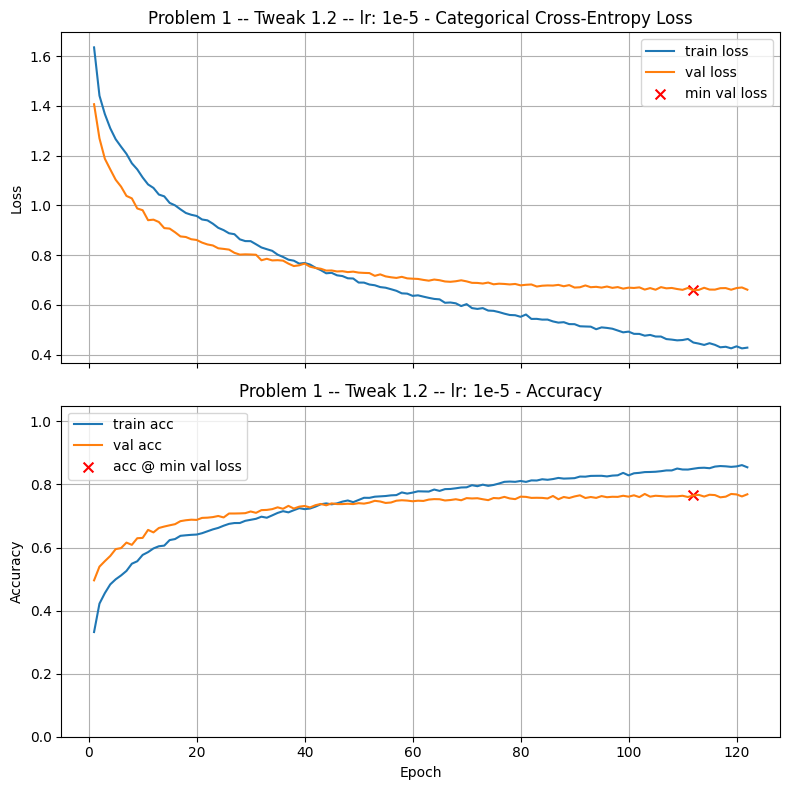

Final Training Loss:            0.4280
Final Training Accuracy:        0.8545
Final Validation Loss:          0.6610
Final Validation Accuracy:      0.7688
Minimum Validation Loss:        0.6590 (Epoch 112)
Validation Accuracy @ Min Loss: 0.7652

Test Loss: 0.6586
Test Accuracy: 0.7660

Validation-Test Gap (accuracy): 0.000770

Execution Time: 00:04:26


In [ ]:
# Adjusting learning rate

he = initializers.HeNormal()                                # best initializer for relu

model_lr2 = models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_lr2, lr_schedule=1e-5, title="Problem 1 -- Tweak 1.2 -- lr: 1e-5")


Problem 1 -- Tweak 2 -- Changing Conv2D widths



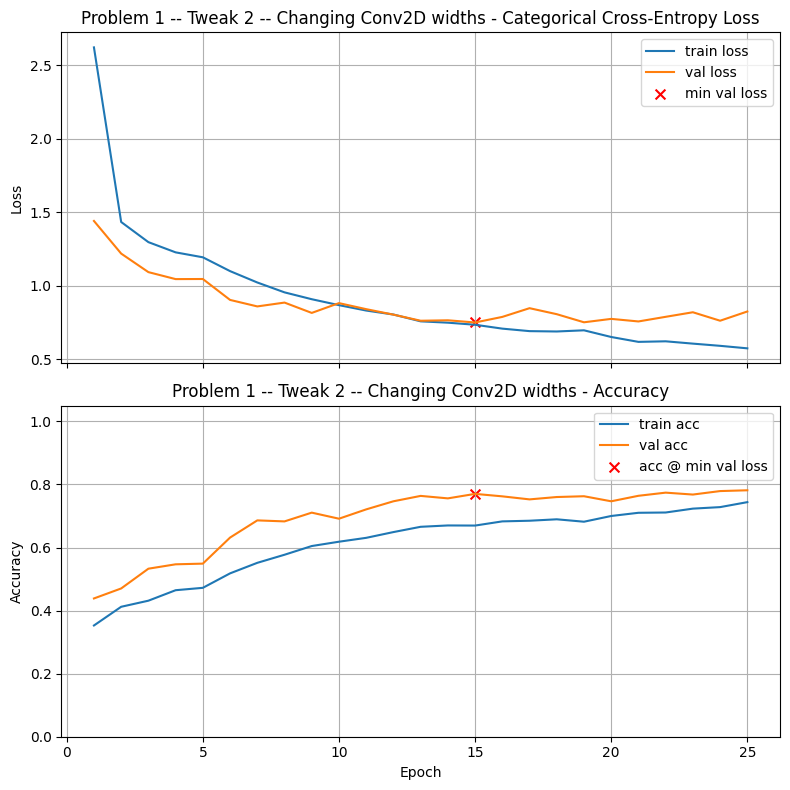

Final Training Loss:            0.5737
Final Training Accuracy:        0.7440
Final Validation Loss:          0.8244
Final Validation Accuracy:      0.7816
Minimum Validation Loss:        0.7496 (Epoch 15)
Validation Accuracy @ Min Loss: 0.7702

Test Loss: 0.7419
Test Accuracy: 0.7693

Validation-Test Gap (accuracy): 0.000884

Execution Time: 00:01:36


In [ ]:
# Changing Conv2D width

he = initializers.HeNormal()                                # best initializer for relu

model_conwidth= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_conwidth,title="Problem 1 -- Tweak 2 -- Changing Conv2D widths")


Problem 1 -- Tweak 3 -- Adding an extra Conv2D layer



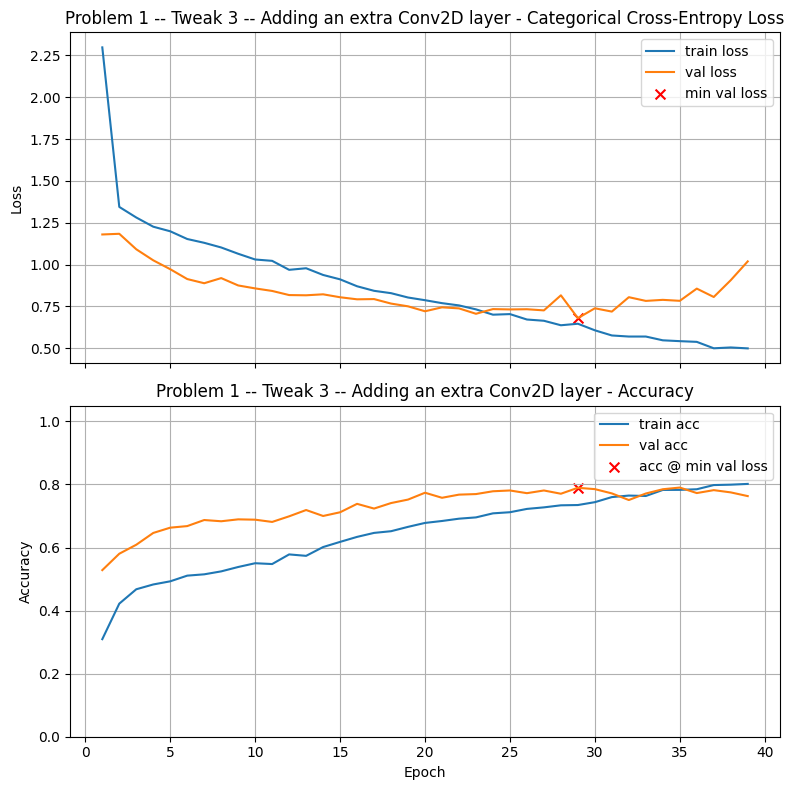

Final Training Loss:            0.4993
Final Training Accuracy:        0.8017
Final Validation Loss:          1.0191
Final Validation Accuracy:      0.7631
Minimum Validation Loss:        0.6801 (Epoch 29)
Validation Accuracy @ Min Loss: 0.7895

Test Loss: 0.6789
Test Accuracy: 0.7903

Validation-Test Gap (accuracy): 0.000878

Execution Time: 00:01:43


In [ ]:
# Adding an extra Conv2D layer

he = initializers.HeNormal()                                # best initializer for relu

model_xtracon= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_xtracon,title="Problem 1 -- Tweak 3 -- Adding an extra Conv2D layer")


Problem 1 -- Tweak 4.1 -- Dense: 32



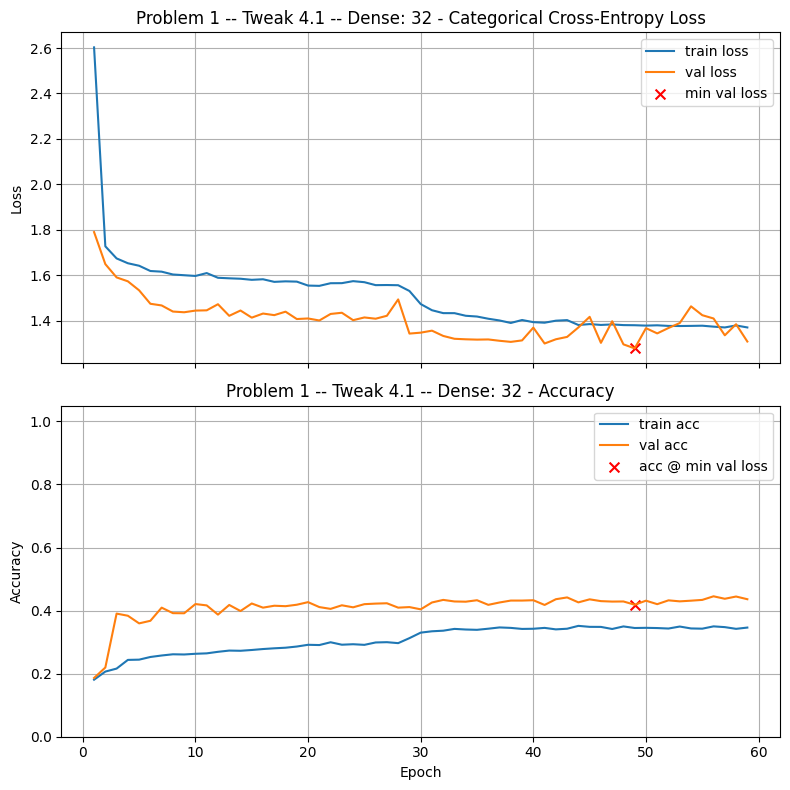

Final Training Loss:            1.3699
Final Training Accuracy:        0.3461
Final Validation Loss:          1.3079
Final Validation Accuracy:      0.4361
Minimum Validation Loss:        1.2778 (Epoch 49)
Validation Accuracy @ Min Loss: 0.4186

Test Loss: 1.2798
Test Accuracy: 0.4243

Validation-Test Gap (accuracy): 0.005737

Execution Time: 00:02:15


In [ ]:
# Changing width of Dense layer

he = initializers.HeNormal()                                # best initializer for relu

model_dense1= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(32, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_dense1,title="Problem 1 -- Tweak 4.1 -- Dense: 32")


Problem 1 -- Tweak 4.2 -- Dense: 16



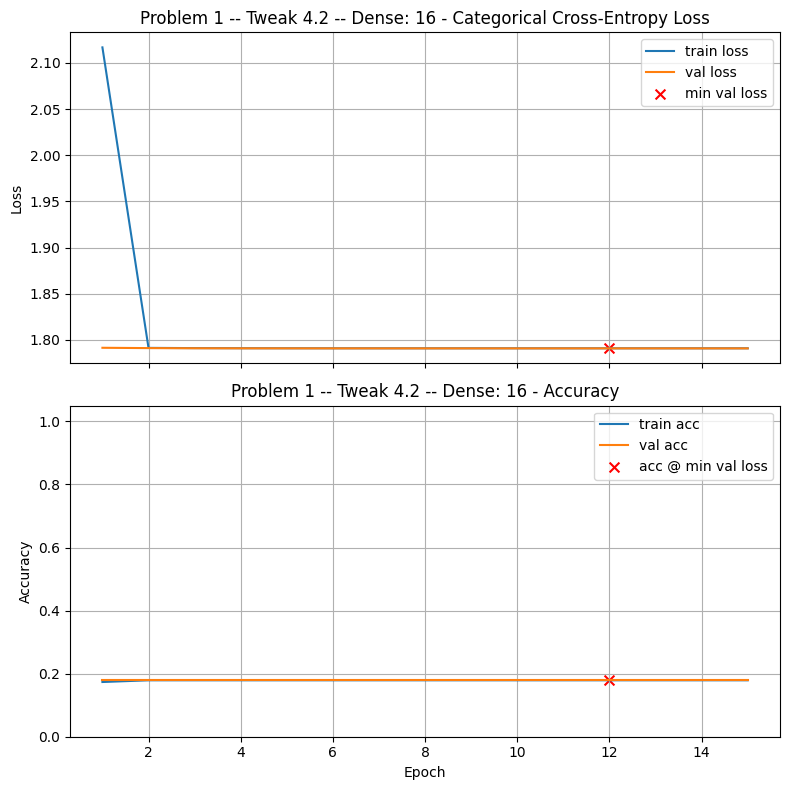

Final Training Loss:            1.7908
Final Training Accuracy:        0.1789
Final Validation Loss:          1.7907
Final Validation Accuracy:      0.1792
Minimum Validation Loss:        1.7907 (Epoch 12)
Validation Accuracy @ Min Loss: 0.1792

Test Loss: 1.7903
Test Accuracy: 0.1750

Validation-Test Gap (accuracy): 0.004195

Execution Time: 00:00:44


In [ ]:
# Changing width of Dense layer

he = initializers.HeNormal()                                # best initializer for relu

model_dense2= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(16, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_dense2,title="Problem 1 -- Tweak 4.2 -- Dense: 16")


Problem 1 -- Tweak 4.3 -- Dense: 128



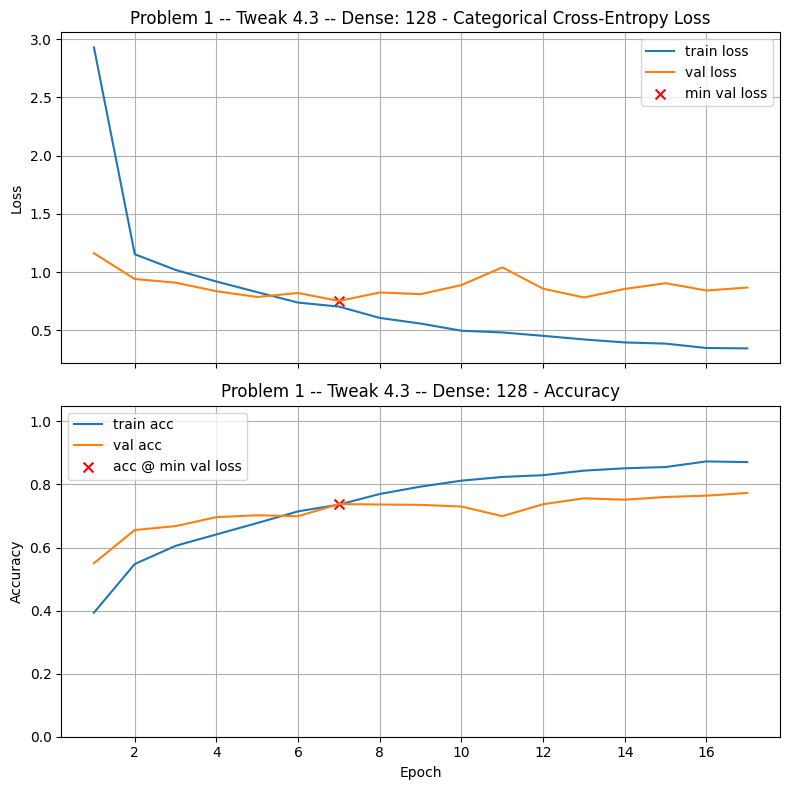

Final Training Loss:            0.3446
Final Training Accuracy:        0.8709
Final Validation Loss:          0.8673
Final Validation Accuracy:      0.7731
Minimum Validation Loss:        0.7518 (Epoch 7)
Validation Accuracy @ Min Loss: 0.7378

Test Loss: 0.7483
Test Accuracy: 0.7323

Validation-Test Gap (accuracy): 0.005465

Execution Time: 00:00:52


In [ ]:
# Changing width of Dense layer

he = initializers.HeNormal()                                # best initializer for relu

model_dense3= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(128, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_dense3,title="Problem 1 -- Tweak 4.3 -- Dense: 128")


Problem 1 -- Tweak 5.1 -- L2 Reg: 1e-4



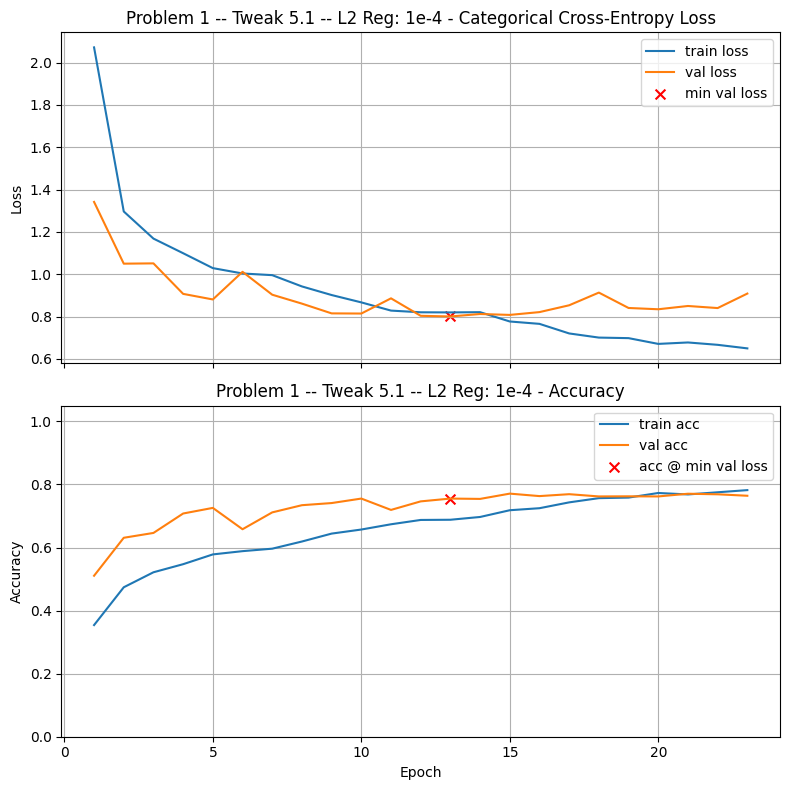

Final Training Loss:            0.6500
Final Training Accuracy:        0.7820
Final Validation Loss:          0.9090
Final Validation Accuracy:      0.7642
Minimum Validation Loss:        0.8008 (Epoch 13)
Validation Accuracy @ Min Loss: 0.7553

Test Loss: 0.7865
Test Accuracy: 0.7593

Validation-Test Gap (accuracy): 0.004079

Execution Time: 00:01:00


In [ ]:
# Adding L2 regularization

he = initializers.HeNormal()                                # best initializer for relu
l2reg = regularizers.l2(1e-4)

model_l2reg1= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he, kernel_regularizer=l2reg),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_l2reg1,title="Problem 1 -- Tweak 5.1 -- L2 Reg: 1e-4")


Problem 1 -- Tweak 5.2 -- L2 Reg: 3e-5



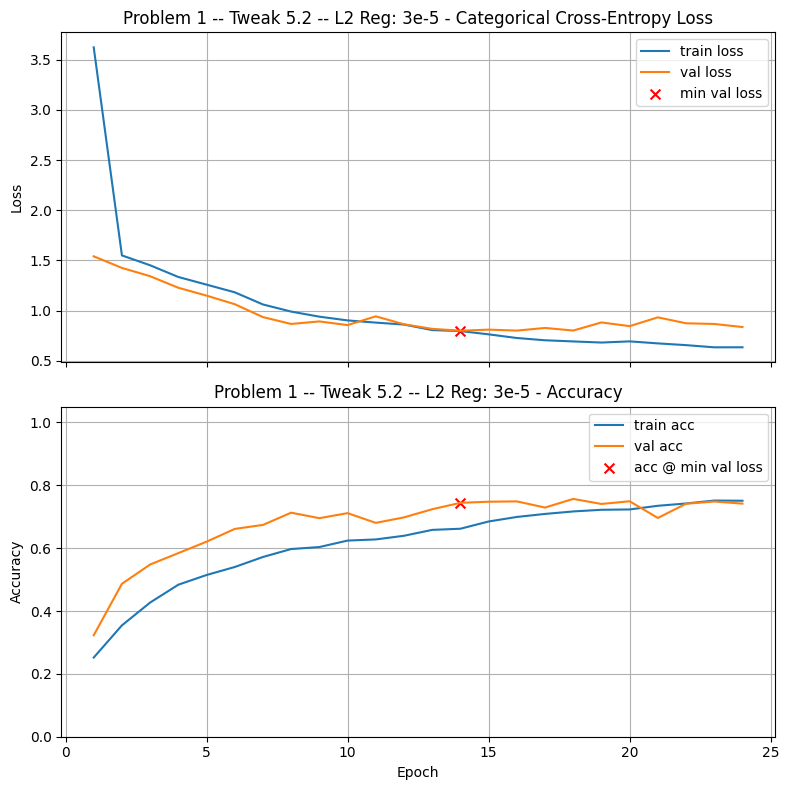

Final Training Loss:            0.6333
Final Training Accuracy:        0.7509
Final Validation Loss:          0.8350
Final Validation Accuracy:      0.7417
Minimum Validation Loss:        0.7982 (Epoch 14)
Validation Accuracy @ Min Loss: 0.7442

Test Loss: 0.7809
Test Accuracy: 0.7550

Validation-Test Gap (accuracy): 0.010789

Execution Time: 00:01:02


In [ ]:
# Adding L2 regularization

he = initializers.HeNormal()                                # best initializer for relu
l2reg = regularizers.l2(3e-5)

model_l2reg2= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he, kernel_regularizer=l2reg),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_l2reg2,title="Problem 1 -- Tweak 5.2 -- L2 Reg: 3e-5")


Problem 1 -- Tweak 6 -- Dropout: 0.3



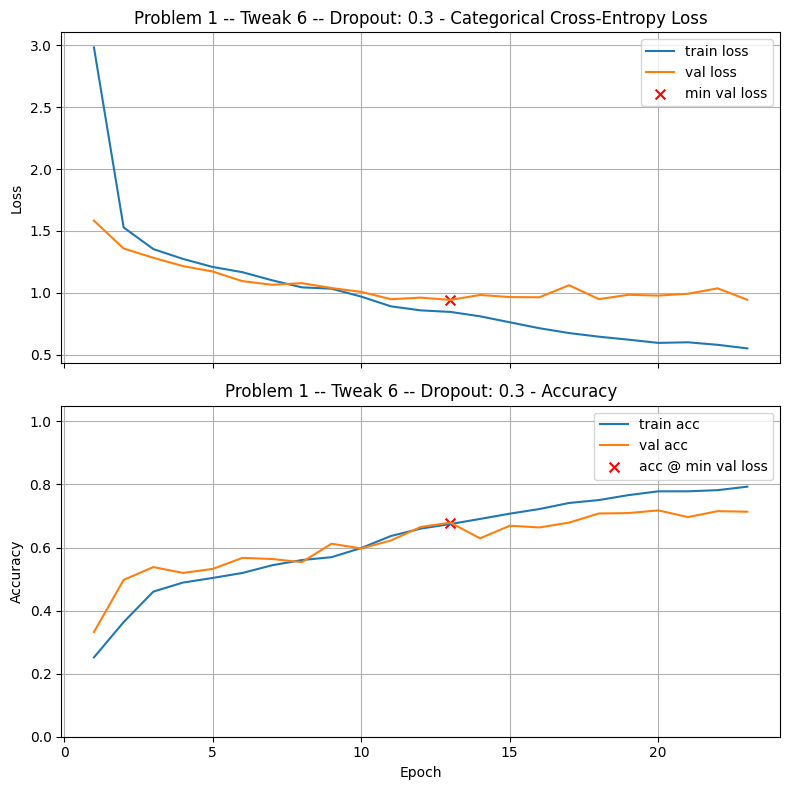

Final Training Loss:            0.5495
Final Training Accuracy:        0.7930
Final Validation Loss:          0.9427
Final Validation Accuracy:      0.7136
Minimum Validation Loss:        0.9415 (Epoch 13)
Validation Accuracy @ Min Loss: 0.6790

Test Loss: 0.9716
Test Accuracy: 0.6697

Validation-Test Gap (accuracy): 0.009350

Execution Time: 00:01:00


In [ ]:
# Modify dropout

he = initializers.HeNormal()                                # best initializer for relu

model_dropout= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_dropout,title="Problem 1 -- Tweak 6 -- Dropout: 0.3")

In [ ]:
print_results()

Problem 1 -- Tweak 3 -- Adding an extra Conv2D layer	0.7895	29
Problem 1 -- Tweak 2 -- Changing Conv2D widths	0.7702	15
Problem 1 -- Tweak 1.2 -- lr: 1e-5      	0.7652	112
Problem 1 -- Tweak 5.1 -- L2 Reg: 1e-4  	0.7553	13
Problem 1 -- Tweak 1.1 -- lr: 1e-4      	0.7524	99
Problem 1 -- Tweak 5.2 -- L2 Reg: 3e-5  	0.7442	14
Baseline Model                          	0.7385	14
Problem 1 -- Tweak 4.3 -- Dense: 128    	0.7378	7
Problem 1 -- Tweak 6 -- Dropout: 0.3    	0.6790	13
Problem 1 -- Tweak 4.1 -- Dense: 32     	0.4186	49
Problem 1 -- Tweak 4.2 -- Dense: 16     	0.1792	12


### Graded Questions

In [ ]:
# Set a1a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 3             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a}')


a1a = 3


In [ ]:
# Set a1b to the validation accuracy found by the choice specified in Question a1a.

a1b = 0.7895             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1b = {a1b:.4f}')

a1b = 0.7895


## Problem Two: Adding Batch Normalization

**Task:**
Take your best model from Problem One and add a `BatchNormalization()` layer immediately after each `Conv2D` layer. Batch normalization helps stabilize training and can improve convergence.

**Next Steps:**

* Train the model with batch normalization included after each `Conv2D` layer.
* Try at least one of tweaks from Problem 1 to see if you can improve your results in this new design.
* Compare the results to your earlier experiments and answer the graded questions.

**Optional:**
Try more than one hyperparameter change alongside batch normalization and see how they interact.




Problem 2 -- Baseline Batch Normalization



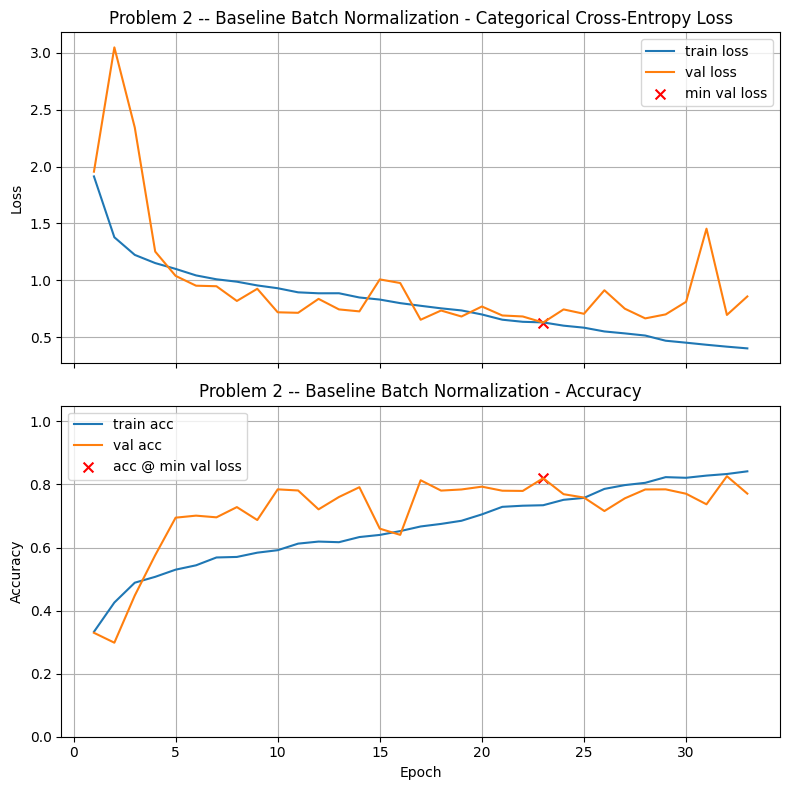

Final Training Loss:            0.4010
Final Training Accuracy:        0.8416
Final Validation Loss:          0.8577
Final Validation Accuracy:      0.7709
Minimum Validation Loss:        0.6280 (Epoch 23)
Validation Accuracy @ Min Loss: 0.8197

Test Loss: 0.5910
Test Accuracy: 0.8283

Validation-Test Gap (accuracy): 0.008597

Execution Time: 00:01:40


In [ ]:
# Your code here, add additional cells if you wish

# Batch Normalization Baseline

he = initializers.HeNormal()                                # best initializer for relu

model_batch_base= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_batch_base,title="Problem 2 -- Baseline Batch Normalization")


Problem 2 -- Tweak 1 -- LR: 1e-4



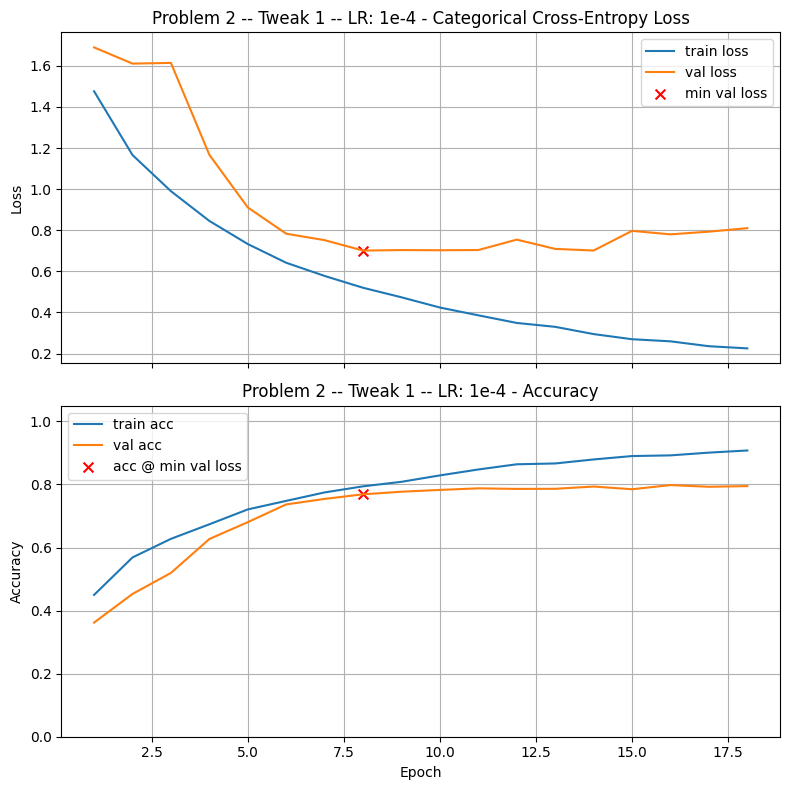

Final Training Loss:            0.2254
Final Training Accuracy:        0.9077
Final Validation Loss:          0.8102
Final Validation Accuracy:      0.7948
Minimum Validation Loss:        0.7011 (Epoch 8)
Validation Accuracy @ Min Loss: 0.7688

Test Loss: 0.6857
Test Accuracy: 0.7630

Validation-Test Gap (accuracy): 0.005792

Execution Time: 00:01:03


In [ ]:
# Adjusing LR

he = initializers.HeNormal()                                # best initializer for relu

model_batch_lr= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_batch_lr, lr_schedule=1e-4, title="Problem 2 -- Tweak 1 -- LR: 1e-4")


Problem 2 -- Tweak 2 -- Changing Conv2D Width



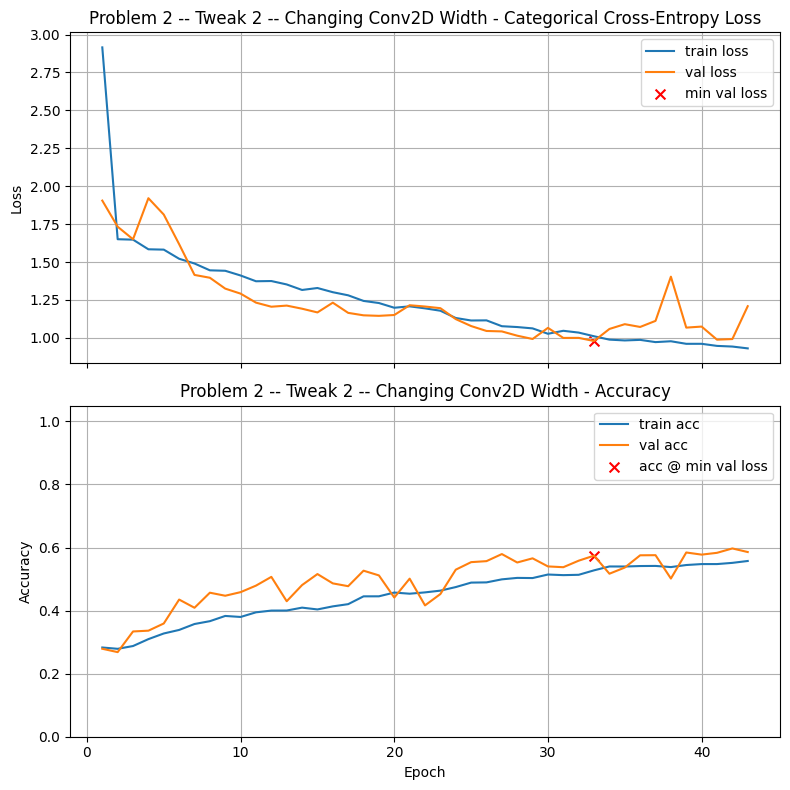

Final Training Loss:            0.9305
Final Training Accuracy:        0.5573
Final Validation Loss:          1.2087
Final Validation Accuracy:      0.5857
Minimum Validation Loss:        0.9791 (Epoch 33)
Validation Accuracy @ Min Loss: 0.5743

Test Loss: 0.9189
Test Accuracy: 0.5643

Validation-Test Gap (accuracy): 0.009945

Execution Time: 00:03:11


In [ ]:
# Changing Conv2D Width

he = initializers.HeNormal()                                # best initializer for relu

model_batch_convwidth= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_batch_convwidth,title="Problem 2 -- Tweak 2 -- Changing Conv2D Width")


Problem 2 -- Tweak 3 -- Adding a Conv2D Layer



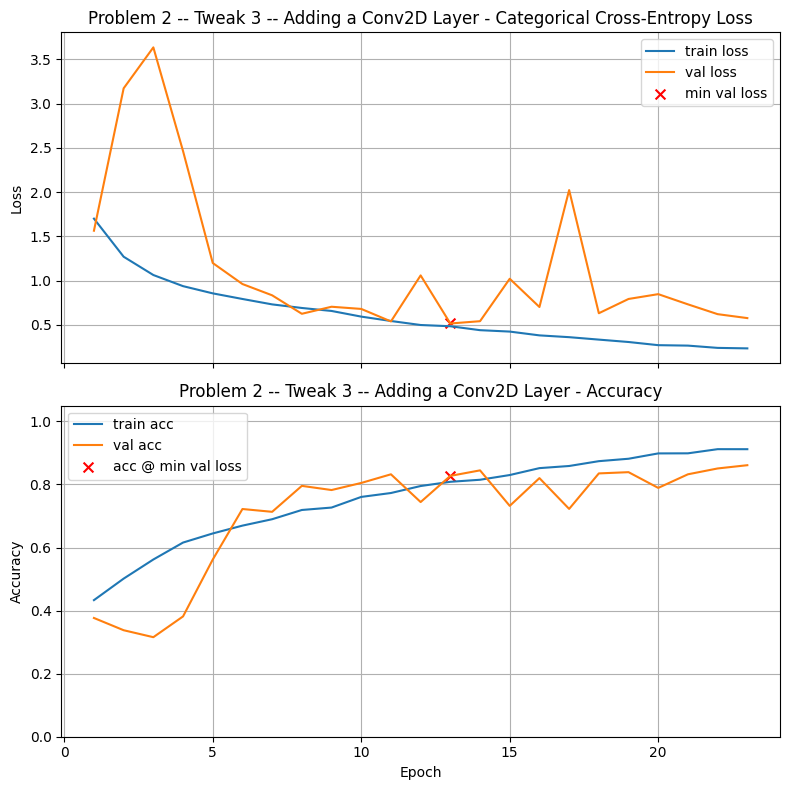

Final Training Loss:            0.2336
Final Training Accuracy:        0.9118
Final Validation Loss:          0.5756
Final Validation Accuracy:      0.8611
Minimum Validation Loss:        0.5148 (Epoch 13)
Validation Accuracy @ Min Loss: 0.8272

Test Loss: 0.5139
Test Accuracy: 0.8377

Validation-Test Gap (accuracy): 0.010449

Execution Time: 00:01:21


In [ ]:
# Adding a Conv2D Layer

he = initializers.HeNormal()                                # best initializer for relu

model_batch_convadd= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_batch_convadd,title="Problem 2 -- Tweak 3 -- Adding a Conv2D Layer")


Problem 2 -- Tweak 4 -- Dense: 32



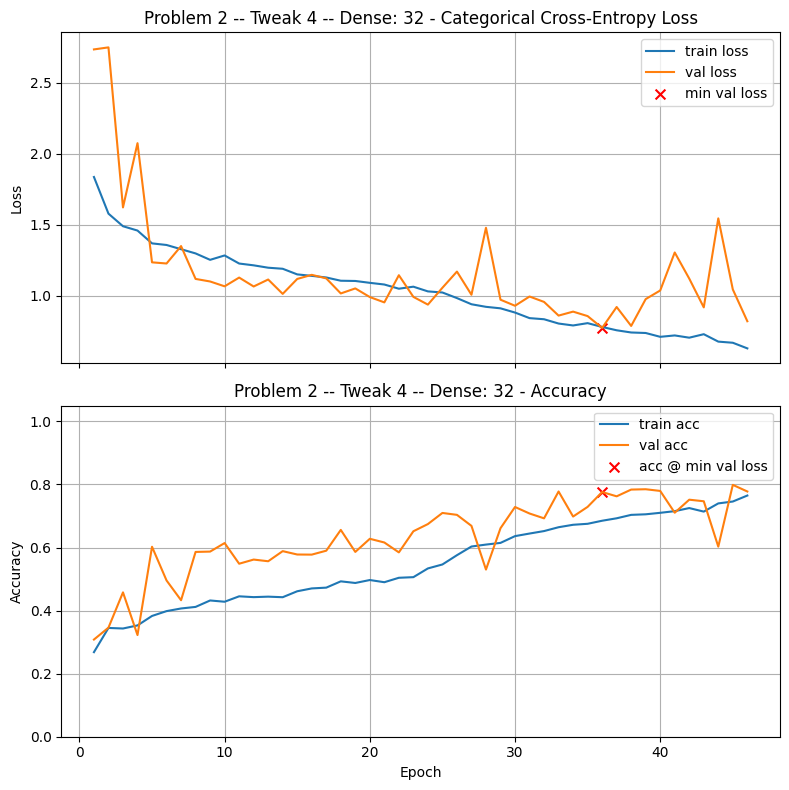

Final Training Loss:            0.6294
Final Training Accuracy:        0.7649
Final Validation Loss:          0.8206
Final Validation Accuracy:      0.7777
Minimum Validation Loss:        0.7737 (Epoch 36)
Validation Accuracy @ Min Loss: 0.7759

Test Loss: 0.7583
Test Accuracy: 0.7847

Validation-Test Gap (accuracy): 0.008749

Execution Time: 00:02:11


In [ ]:
# Changing Width of Dense

he = initializers.HeNormal()                                # best initializer for relu

model_batch_dense= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(32, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_batch_dense,title="Problem 2 -- Tweak 4 -- Dense: 32")


Problem 2 -- Tweak 5 -- L2 Regularization: 1e-5



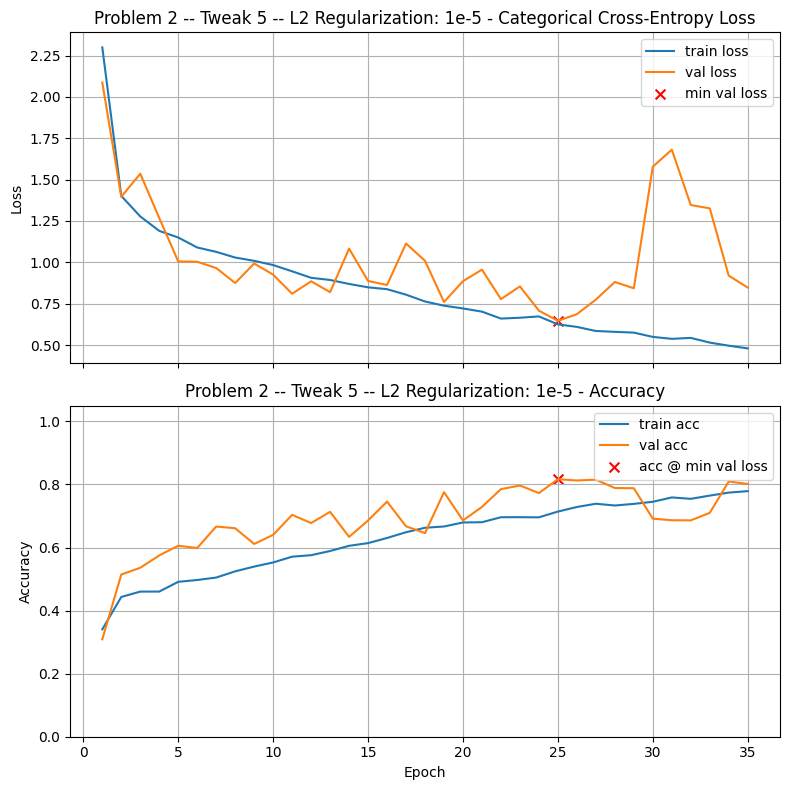

Final Training Loss:            0.4797
Final Training Accuracy:        0.7788
Final Validation Loss:          0.8475
Final Validation Accuracy:      0.8016
Minimum Validation Loss:        0.6462 (Epoch 25)
Validation Accuracy @ Min Loss: 0.8165

Test Loss: 0.6547
Test Accuracy: 0.8203

Validation-Test Gap (accuracy): 0.003803

Execution Time: 00:01:44


In [ ]:
# Adding L2 Regularization

he = initializers.HeNormal()                                # best initializer for relu
l2reg = regularizers.l2(1e-5)

model_batch_l2reg= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he, kernel_regularizer=l2reg),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_batch_l2reg,title="Problem 2 -- Tweak 5 -- L2 Regularization: 1e-5")


Problem 2 -- Tweak 6 -- Dropout: 0.3



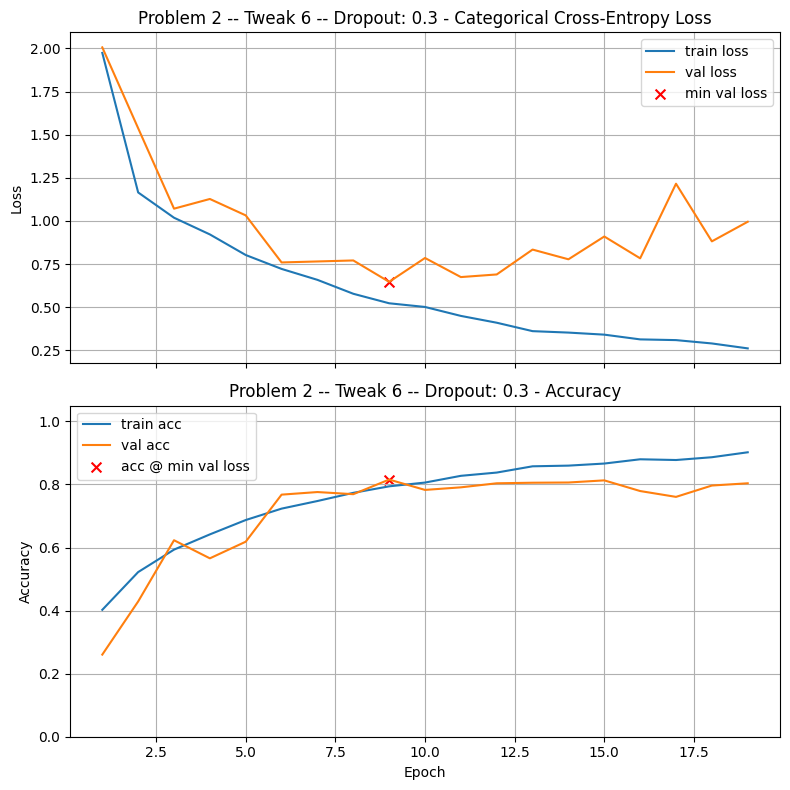

Final Training Loss:            0.2617
Final Training Accuracy:        0.9020
Final Validation Loss:          0.9954
Final Validation Accuracy:      0.8037
Minimum Validation Loss:        0.6472 (Epoch 9)
Validation Accuracy @ Min Loss: 0.8155

Test Loss: 0.6097
Test Accuracy: 0.8130

Validation-Test Gap (accuracy): 0.002461

Execution Time: 00:01:04


In [ ]:
# Modify Dropout Rate

he = initializers.HeNormal()                                # best initializer for relu

model_batch_dropout= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_batch_dropout,title="Problem 2 -- Tweak 6 -- Dropout: 0.3")

In [ ]:
print_results()

Problem 2 -- Tweak 3 -- Adding a Conv2D Layer	0.8272	13
Problem 2 -- Baseline Batch Normalization	0.8197	23
Problem 2 -- Tweak 5 -- L2 Regularization: 1e-5	0.8165	25
Problem 2 -- Tweak 6 -- Dropout: 0.3    	0.8155	9
Problem 1 -- Tweak 3 -- Adding an extra Conv2D layer	0.7895	29
Problem 2 -- Tweak 4 -- Dense: 32       	0.7759	36
Problem 1 -- Tweak 2 -- Changing Conv2D widths	0.7702	15
Problem 2 -- Tweak 1 -- LR: 1e-4        	0.7688	8
Problem 1 -- Tweak 1.2 -- lr: 1e-5      	0.7652	112
Problem 1 -- Tweak 5.1 -- L2 Reg: 1e-4  	0.7553	13
Problem 1 -- Tweak 1.1 -- lr: 1e-4      	0.7524	99
Problem 1 -- Tweak 5.2 -- L2 Reg: 3e-5  	0.7442	14
Baseline Model                          	0.7385	14
Problem 1 -- Tweak 4.3 -- Dense: 128    	0.7378	7
Problem 1 -- Tweak 6 -- Dropout: 0.3    	0.6790	13
Problem 2 -- Tweak 2 -- Changing Conv2D Width	0.5743	33
Problem 1 -- Tweak 4.1 -- Dense: 32     	0.4186	49
Problem 1 -- Tweak 4.2 -- Dense: 16     	0.1792	12


### Graded Questions

In [ ]:
# Set a2a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 3             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a}')


a2a = 3


In [ ]:
# Set a2b to the validation accuracy found by the choice specified in Question a2a (your best model for this problem)

a2b = 0.8272             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2b = {a2b:.4f}')

a2b = 0.8272


## Problem Three: Global Average Pooling

As we saw in this week's Coding Video,
**Global Average Pooling** is a simple layer that replaces the `Flatten → Dense` part of a CNN (please review that part of the Coding Notebook, which contains a description of this important technique).

In practice, swapping `Flatten` for `GlobalAveragePooling2D` often improves stability and validation performance — definitely worth considering!


**Task:**
Modify your best model from Problems 1 & 2 to use a `GlobalAveragePooling2D()` layer instead of a flatten-and-dense block.

**Next Steps:**

* Replace the sequence between the last `Conv2D` and output layers, for example:

     
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(64, activation='relu', kernel_initializer=initializers.HeNormal()),
          Dropout(0.5),   

  with a single `GlobalAveragePooling2D()` layer.
* Train the model and observe how performance and training curves change.
* Try at least one of tweaks from Problem 1 to see if you can improve your results in this new design.
* Compare results and answer the graded questions.

**Optional:**
Experiment with `GlobalMaxPooling2D()` as an alternative and compare its behavior to `GlobalAveragePooling2D()`.




Problem 3 -- GAP Baseline



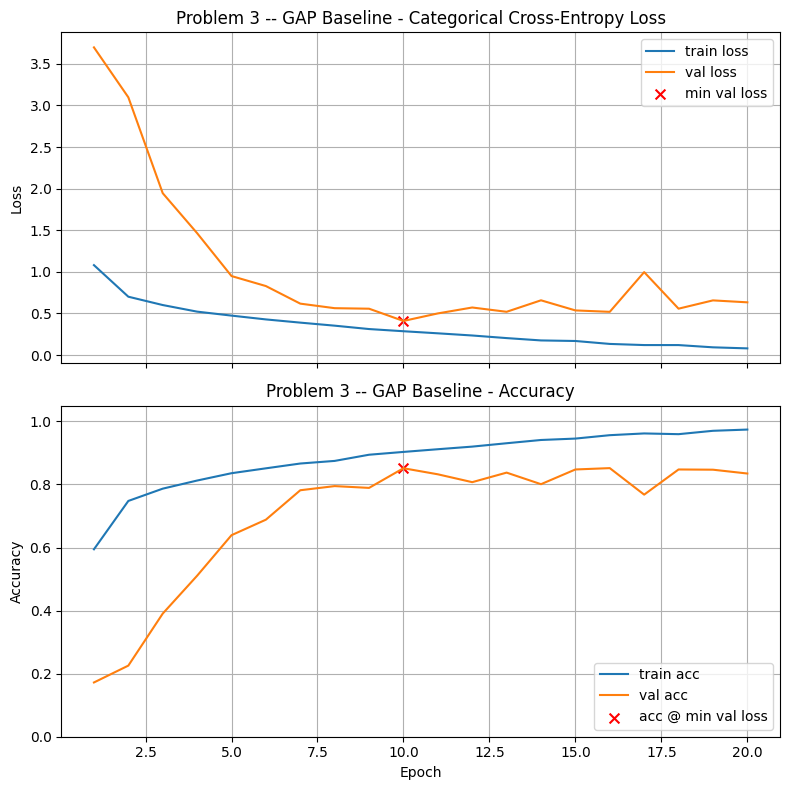

Final Training Loss:            0.0803
Final Training Accuracy:        0.9741
Final Validation Loss:          0.6336
Final Validation Accuracy:      0.8347
Minimum Validation Loss:        0.4099 (Epoch 10)
Validation Accuracy @ Min Loss: 0.8514

Test Loss: 0.4086
Test Accuracy: 0.8533

Validation-Test Gap (accuracy): 0.001891

Execution Time: 00:01:25


In [ ]:
# Your code here, add additional cells if you wish

he = initializers.HeNormal()                                # best initializer for relu

model_gap= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap,title="Problem 3 -- GAP Baseline")


Problem 3 -- Tweak 1.1 -- LR: 1e-4



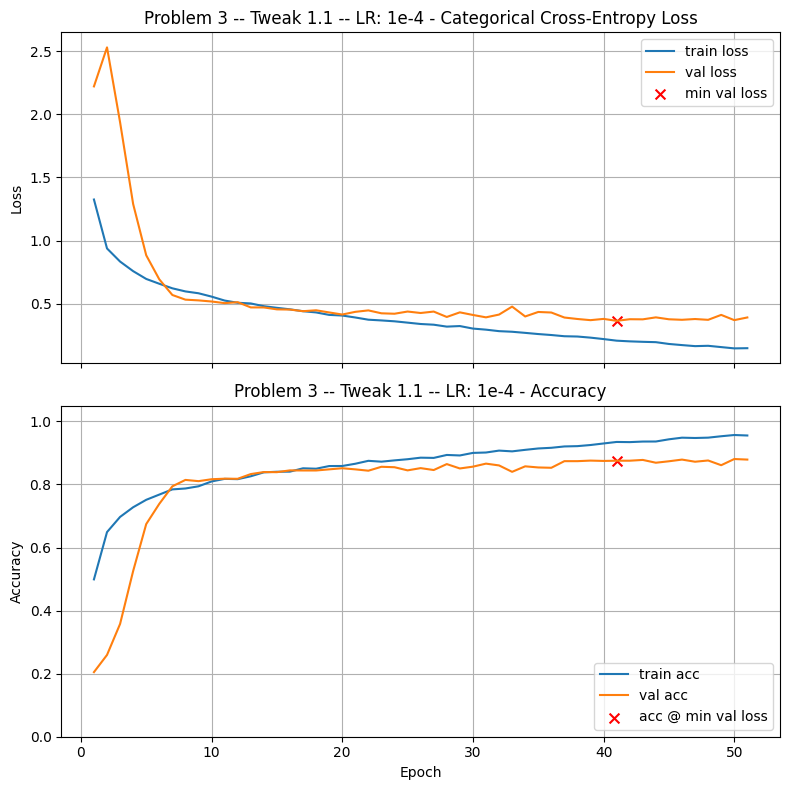

Final Training Loss:            0.1487
Final Training Accuracy:        0.9553
Final Validation Loss:          0.3918
Final Validation Accuracy:      0.8789
Minimum Validation Loss:        0.3651 (Epoch 41)
Validation Accuracy @ Min Loss: 0.8753

Test Loss: 0.3756
Test Accuracy: 0.8700

Validation-Test Gap (accuracy): 0.005312

Execution Time: 00:02:37


In [ ]:
# Adjusting LR

he = initializers.HeNormal()                                # best initializer for relu

model_gap_lr1= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap_lr1, lr_schedule=1e-4, title="Problem 3 -- Tweak 1.1 -- LR: 1e-4")


Problem 3 -- Tweak 1.2 -- LR: 1e-5



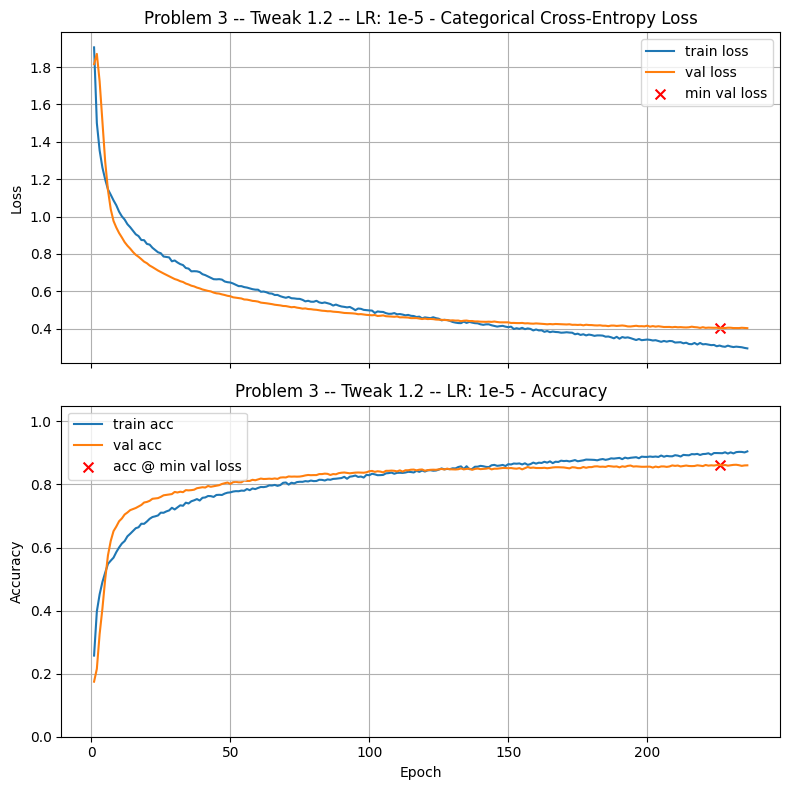

Final Training Loss:            0.2947
Final Training Accuracy:        0.9049
Final Validation Loss:          0.4029
Final Validation Accuracy:      0.8607
Minimum Validation Loss:        0.4026 (Epoch 226)
Validation Accuracy @ Min Loss: 0.8621

Test Loss: 0.3923
Test Accuracy: 0.8587

Validation-Test Gap (accuracy): 0.003464

Execution Time: 00:10:49


In [ ]:
# Adjusting LR

he = initializers.HeNormal()                                # best initializer for relu

model_gap_lr2= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap_lr2, lr_schedule=1e-5, title="Problem 3 -- Tweak 1.2 -- LR: 1e-5")


Problem 3 -- Tweak 2 -- Changing Conv2D Width



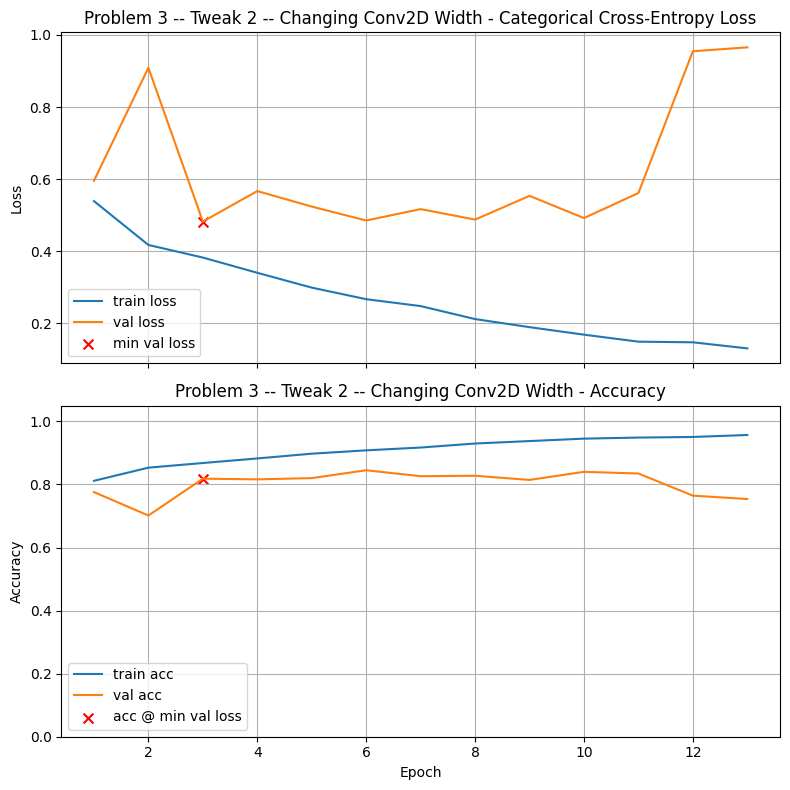

Final Training Loss:            0.1296
Final Training Accuracy:        0.9569
Final Validation Loss:          0.9656
Final Validation Accuracy:      0.7538
Minimum Validation Loss:        0.4819 (Epoch 3)
Validation Accuracy @ Min Loss: 0.8183

Test Loss: 0.4910
Test Accuracy: 0.8177

Validation-Test Gap (accuracy): 0.000645

Execution Time: 00:00:54


In [ ]:
# Changing Width of Conv2D

he = initializers.HeNormal()                                # best initializer for relu

model_gap_convwidth= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(512, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap_convwidth, title="Problem 3 -- Tweak 2 -- Changing Conv2D Width")


Problem 3 -- Tweak 3 -- Adding Conv2D Layer



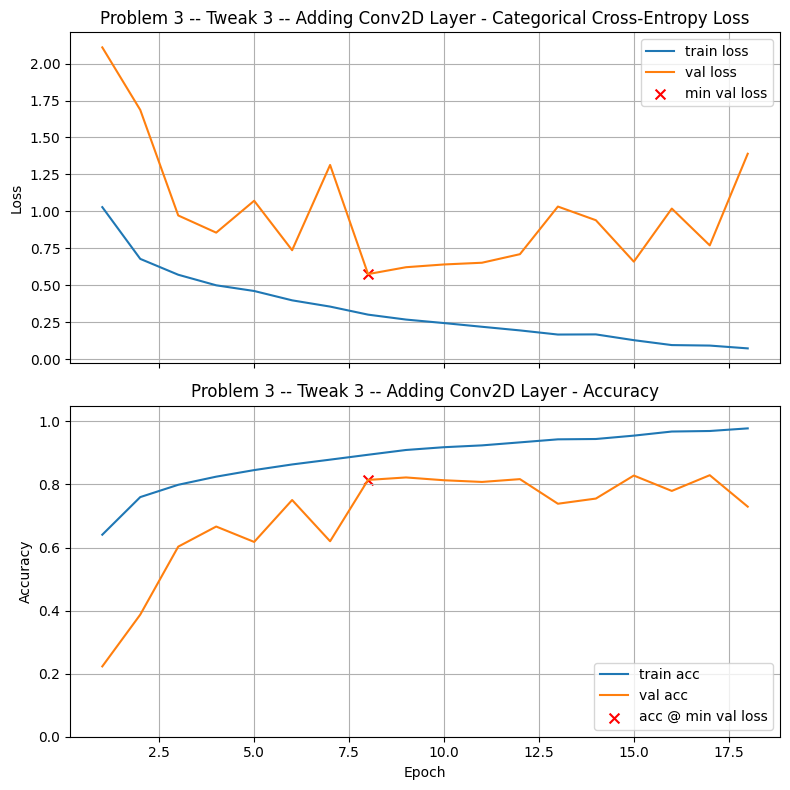

Final Training Loss:            0.0721
Final Training Accuracy:        0.9778
Final Validation Loss:          1.3896
Final Validation Accuracy:      0.7296
Minimum Validation Loss:        0.5749 (Epoch 8)
Validation Accuracy @ Min Loss: 0.8144

Test Loss: 0.5533
Test Accuracy: 0.8190

Validation-Test Gap (accuracy): 0.004607

Execution Time: 00:01:27


In [ ]:
# Adding Conv2D layer

he = initializers.HeNormal()                                # best initializer for relu

model_gap_conv2add= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(512, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap_conv2add, title="Problem 3 -- Tweak 3 -- Adding Conv2D Layer")


Problem 3 -- Tweak 4 -- Dense: 32



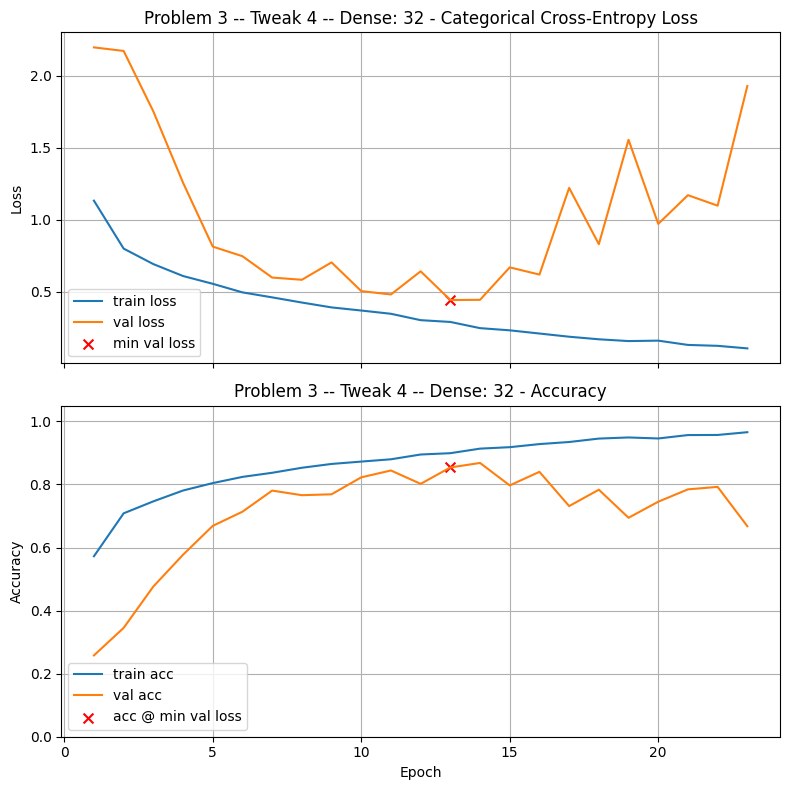

Final Training Loss:            0.1071
Final Training Accuracy:        0.9657
Final Validation Loss:          1.9283
Final Validation Accuracy:      0.6676
Minimum Validation Loss:        0.4428 (Epoch 13)
Validation Accuracy @ Min Loss: 0.8539

Test Loss: 0.4157
Test Accuracy: 0.8610

Validation-Test Gap (accuracy): 0.007063

Execution Time: 00:01:29


In [ ]:
# Changing Dense width

he = initializers.HeNormal()                                # best initializer for relu

model_gap_dense= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(32, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap_dense, title="Problem 3 -- Tweak 4 -- Dense: 32")


Problem 3 -- Tweak 5.1 -- L2 Reg: 1e-4



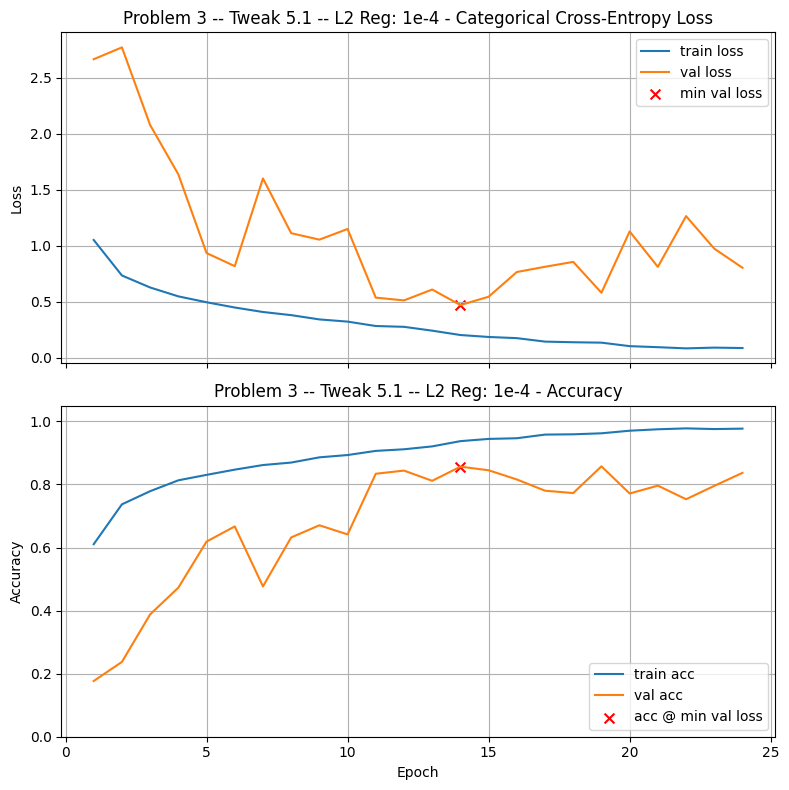

Final Training Loss:            0.0874
Final Training Accuracy:        0.9770
Final Validation Loss:          0.8033
Final Validation Accuracy:      0.8368
Minimum Validation Loss:        0.4706 (Epoch 14)
Validation Accuracy @ Min Loss: 0.8564

Test Loss: 0.4273
Test Accuracy: 0.8620

Validation-Test Gap (accuracy): 0.005570

Execution Time: 00:01:24


In [ ]:
# Adding L2 Regularization

he = initializers.HeNormal()                                # best initializer for relu
l2reg = regularizers.l2(1e-4)

model_gap_l2reg1= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he, kernel_regularizer=l2reg),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap_l2reg1,title="Problem 3 -- Tweak 5.1 -- L2 Reg: 1e-4")


Problem 3 -- Tweak 5.2 -- L2 Reg: 1e-5



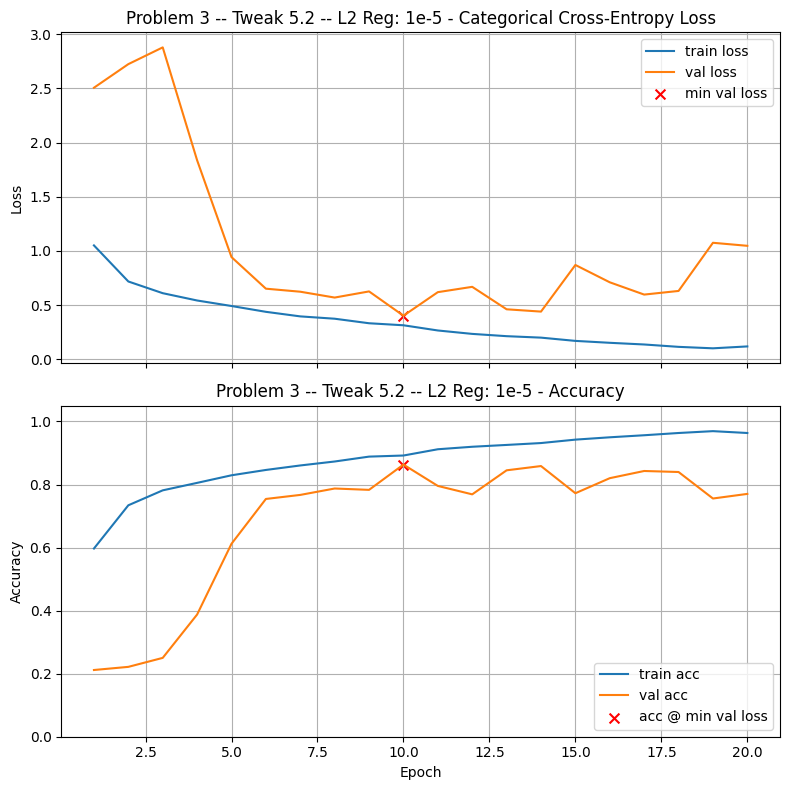

Final Training Loss:            0.1182
Final Training Accuracy:        0.9634
Final Validation Loss:          1.0469
Final Validation Accuracy:      0.7702
Minimum Validation Loss:        0.4018 (Epoch 10)
Validation Accuracy @ Min Loss: 0.8632

Test Loss: 0.3932
Test Accuracy: 0.8583

Validation-Test Gap (accuracy): 0.004866

Execution Time: 00:01:15


In [ ]:
# Adding L2 Regularization

he = initializers.HeNormal()                                # best initializer for relu
l2reg = regularizers.l2(1e-5)

model_gap_l2reg2= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he, kernel_regularizer=l2reg),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap_l2reg2,title="Problem 3 -- Tweak 5.2 -- L2 Reg: 1e-5")


Problem 3 -- Tweak 6 -- Dropout: 0.3



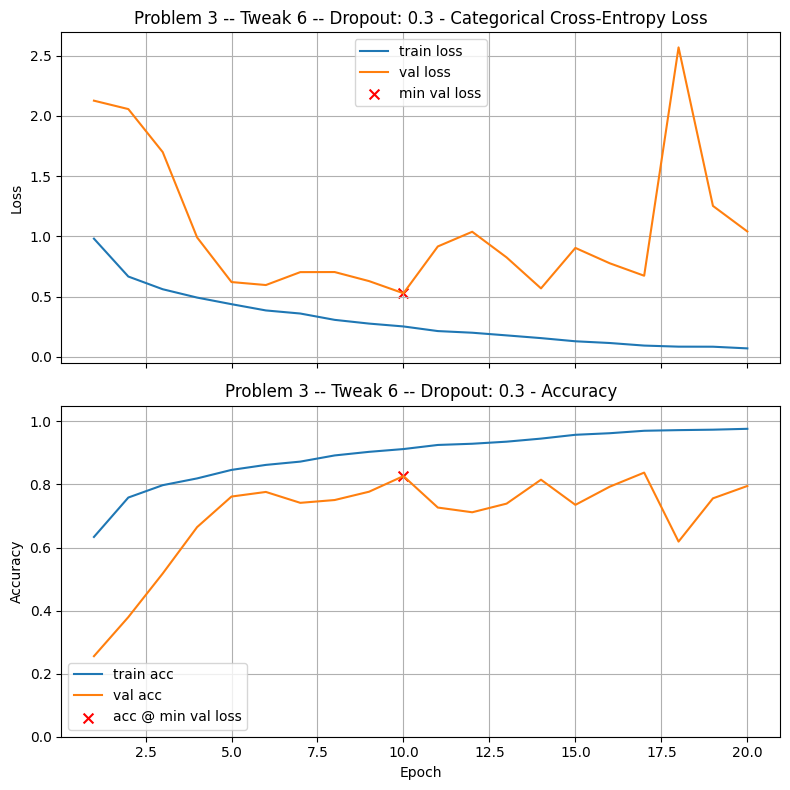

Final Training Loss:            0.0699
Final Training Accuracy:        0.9765
Final Validation Loss:          1.0410
Final Validation Accuracy:      0.7952
Minimum Validation Loss:        0.5276 (Epoch 10)
Validation Accuracy @ Min Loss: 0.8265

Test Loss: 0.5047
Test Accuracy: 0.8333

Validation-Test Gap (accuracy): 0.006828

Execution Time: 00:01:13


In [ ]:
# Modify Dropout Rate

he = initializers.HeNormal()                                # best initializer for relu

model_gap_dropout= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap_dropout,title="Problem 3 -- Tweak 6 -- Dropout: 0.3")

In [ ]:
print_results()

Problem 3 -- Tweak 1.1 -- LR: 1e-4      	0.8753	41
Problem 3 -- Tweak 5.2 -- L2 Reg: 1e-5  	0.8632	10
Problem 3 -- Tweak 1.2 -- LR: 1e-5      	0.8621	226
Problem 3 -- Tweak 5.1 -- L2 Reg: 1e-4  	0.8564	14
Problem 3 -- Tweak 4 -- Dense: 32       	0.8539	13
Problem 3 -- GAP Baseline               	0.8514	10
Problem 2 -- Tweak 3 -- Adding a Conv2D Layer	0.8272	13
Problem 3 -- Tweak 6 -- Dropout: 0.3    	0.8265	10
Problem 2 -- Baseline Batch Normalization	0.8197	23
Problem 3 -- Tweak 2 -- Changing Conv2D Width	0.8183	3
Problem 2 -- Tweak 5 -- L2 Regularization: 1e-5	0.8165	25
Problem 2 -- Tweak 6 -- Dropout: 0.3    	0.8155	9
Problem 3 -- Tweak 3 -- Adding Conv2D Layer	0.8144	8
Problem 1 -- Tweak 3 -- Adding an extra Conv2D layer	0.7895	29
Problem 2 -- Tweak 4 -- Dense: 32       	0.7759	36
Problem 1 -- Tweak 2 -- Changing Conv2D widths	0.7702	15
Problem 2 -- Tweak 1 -- LR: 1e-4        	0.7688	8
Problem 1 -- Tweak 1.2 -- lr: 1e-5      	0.7652	112
Problem 1 -- Tweak 5.1 -- L2 Reg: 1e-4  	0.75

### Graded Questions

In [ ]:
# Set a3a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a3a = 1             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3a = {a3a}')


a3a = 1


In [ ]:
# Set a3b to the validation accuracy found by the choice specified in Question a3a (your best model for this problem)

a3b = 0.8753             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3b = {a3b:.4f}')

a3b = 0.8753


## Problem Four: ReduceLROnPlateau

`ReduceLROnPlateau` is a widely used learning rate scheduling technique. It monitors a validation metric (usually `val_loss`) and reduces the learning rate when progress stalls, allowing the model to refine training at a smaller step size. This is one of the most useful scheduling tools (along with the essential Early Stopping) to have in your toolbox.

**Task:**
Augment your best model found so far in Problems 1 - 3 with the `ReduceLROnPlateau` callback during training.

**Next Steps:**

* Add the callback parameter to `train_and_test`:

  ```python
  callbacks=[reduce_lr]
  ```

* Start with **`factor=0.5`** (monitor `val_loss`, `patience=2–3`, `cooldown=1`, `min_lr=1e-5` for Adam).
* **Practical playbook:**

  * If plateau persists after one reduction → try **`factor=0.3`**, then **`0.2`**.
  * If a reduction hurts validation noticeably → try **`factor=0.7–0.8`** or increase **`patience`**.
  * Leave **`cooldown=1`** unless you see too-frequent drops.
* Experiment with **`patience` = 3, 5, 8** and **`min_delta` = `1e-4` vs `1e-3`** to gauge sensitivity.
* Choose the configuration with the best validation results—or note that ReduceLROnPlateau didn’t help (rare!).
* Answer the graded questions.




Problem 4 -- factor: 0.5



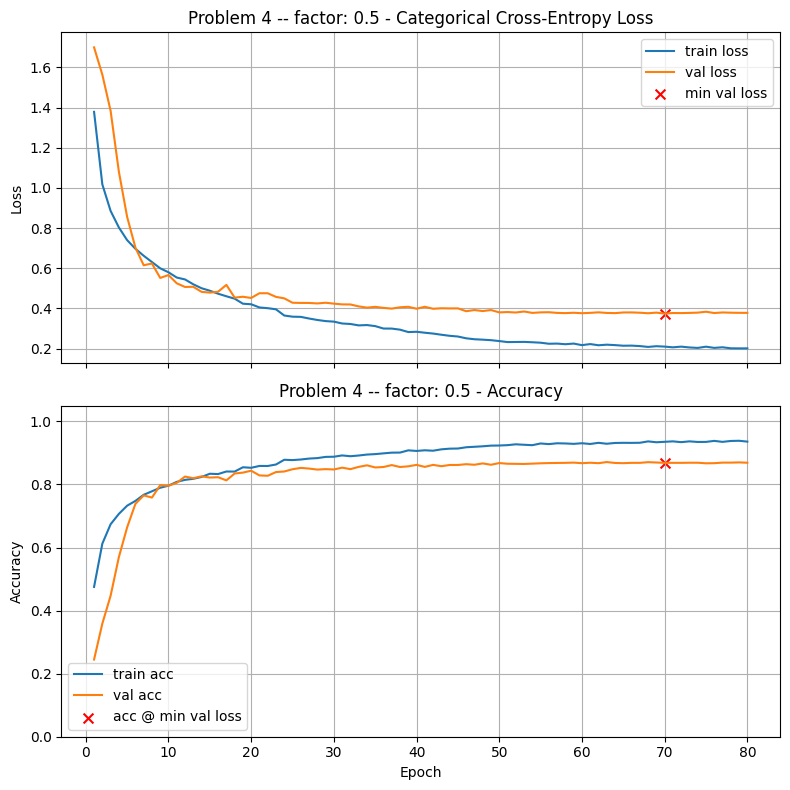

Final Training Loss:            0.2010
Final Training Accuracy:        0.9359
Final Validation Loss:          0.3777
Final Validation Accuracy:      0.8689
Minimum Validation Loss:        0.3742 (Epoch 70)
Validation Accuracy @ Min Loss: 0.8685

Test Loss: 0.3600
Test Accuracy: 0.8763

Validation-Test Gap (accuracy): 0.007790

Execution Time: 00:03:57


In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

# Your code here, add more cells as needed

he = initializers.HeNormal()                                # best initializer for relu

model_reducelr= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_reducelr, lr_schedule=1e-4, title="Problem 4 -- factor: 0.5", callbacks=[reduce_lr])


Problem 4 -- factor: 0.3



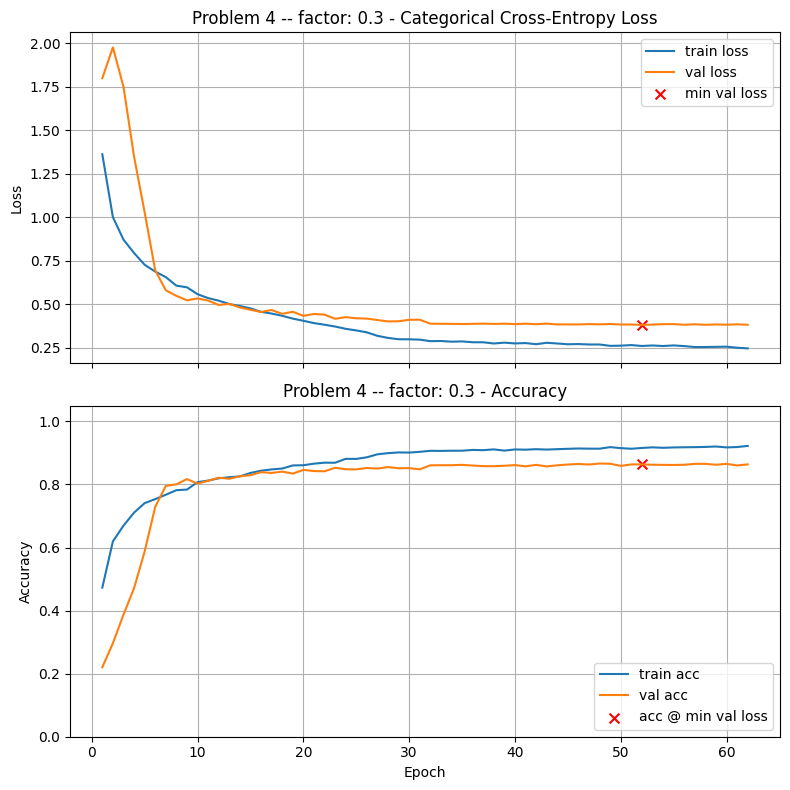

Final Training Loss:            0.2468
Final Training Accuracy:        0.9222
Final Validation Loss:          0.3827
Final Validation Accuracy:      0.8636
Minimum Validation Loss:        0.3818 (Epoch 52)
Validation Accuracy @ Min Loss: 0.8636

Test Loss: 0.3536
Test Accuracy: 0.8730

Validation-Test Gap (accuracy): 0.009445

Execution Time: 00:03:07


In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.3,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

# Your code here, add more cells as needed

he = initializers.HeNormal()                                # best initializer for relu

model_reducelr2= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_reducelr2, lr_schedule=1e-4, title="Problem 4 -- factor: 0.3", callbacks=[reduce_lr])


Problem 4 -- factor: 0.7



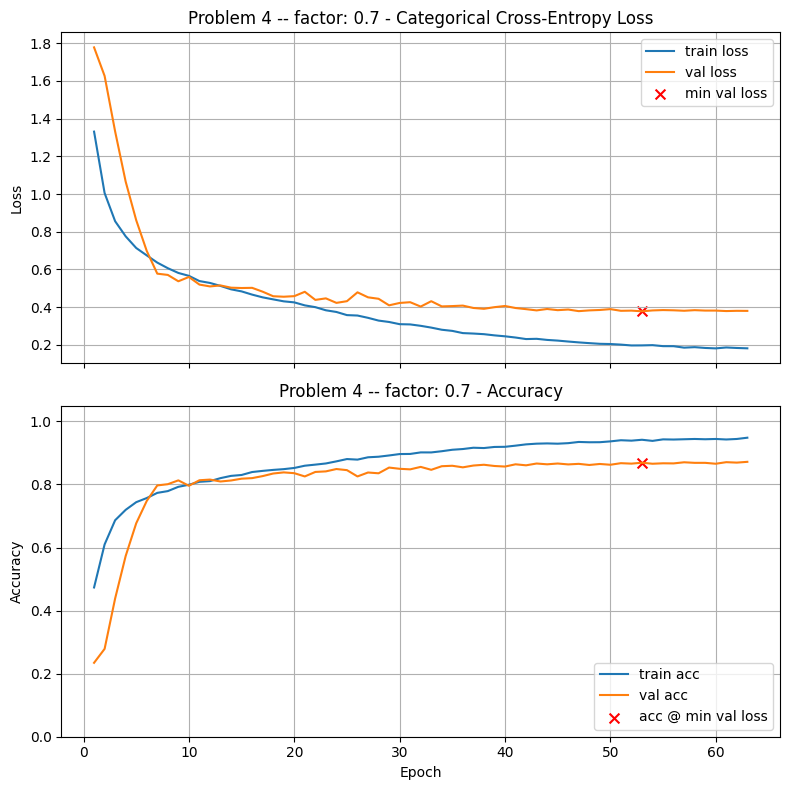

Final Training Loss:            0.1821
Final Training Accuracy:        0.9482
Final Validation Loss:          0.3806
Final Validation Accuracy:      0.8717
Minimum Validation Loss:        0.3783 (Epoch 53)
Validation Accuracy @ Min Loss: 0.8689

Test Loss: 0.3522
Test Accuracy: 0.8737

Validation-Test Gap (accuracy): 0.004767

Execution Time: 00:03:09


In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.7,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

# Your code here, add more cells as needed

he = initializers.HeNormal()                                # best initializer for relu

model_reducelr3= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_reducelr3, lr_schedule=1e-4, title="Problem 4 -- factor: 0.7", callbacks=[reduce_lr])


Problem 4 -- factor: 0.8, patience: 5



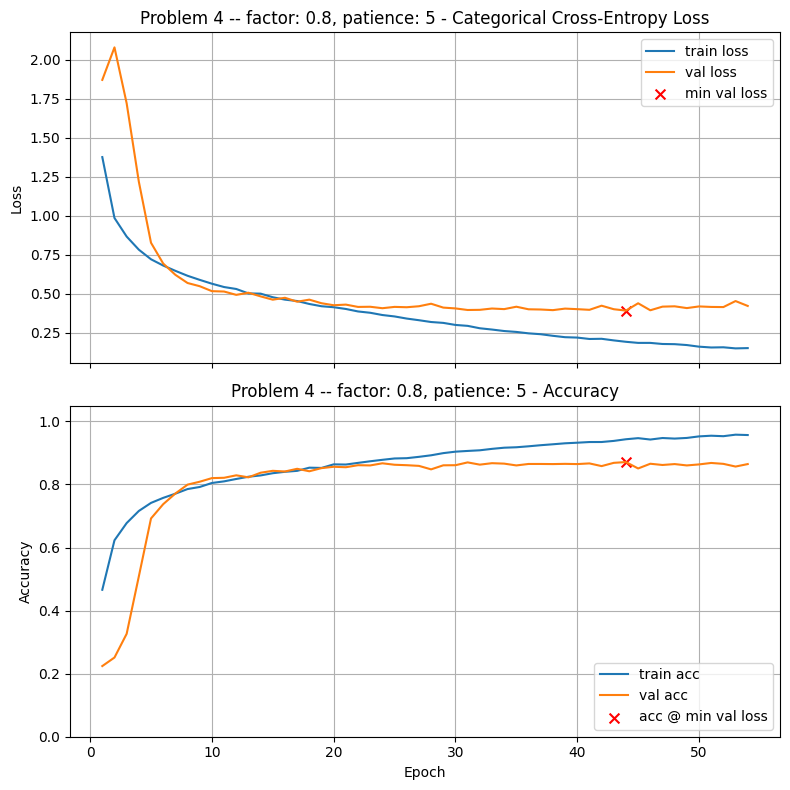

Final Training Loss:            0.1523
Final Training Accuracy:        0.9567
Final Validation Loss:          0.4224
Final Validation Accuracy:      0.8646
Minimum Validation Loss:        0.3925 (Epoch 44)
Validation Accuracy @ Min Loss: 0.8710

Test Loss: 0.3774
Test Accuracy: 0.8757

Validation-Test Gap (accuracy): 0.004630

Execution Time: 00:02:47


In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.8,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

# Your code here, add more cells as needed

he = initializers.HeNormal()                                # best initializer for relu

model_reducelr4= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_reducelr4, lr_schedule=1e-4, title="Problem 4 -- factor: 0.8, patience: 5", callbacks=[reduce_lr])


Problem 4 -- factor: 0.8, patience: 8



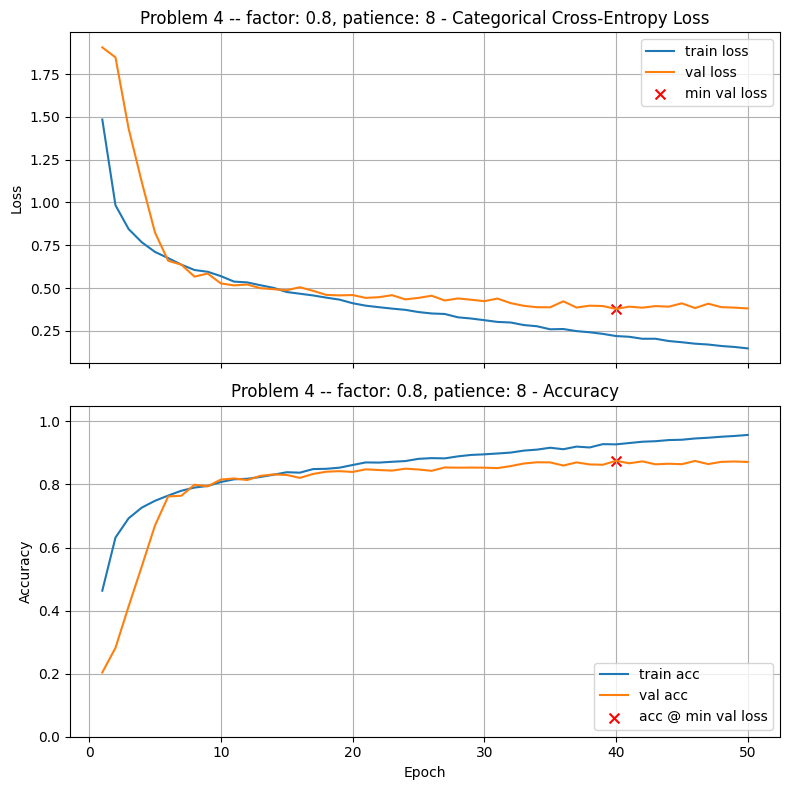

Final Training Loss:            0.1475
Final Training Accuracy:        0.9571
Final Validation Loss:          0.3809
Final Validation Accuracy:      0.8714
Minimum Validation Loss:        0.3781 (Epoch 40)
Validation Accuracy @ Min Loss: 0.8750

Test Loss: 0.3709
Test Accuracy: 0.8777

Validation-Test Gap (accuracy): 0.002711

Execution Time: 00:02:34


In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.8,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=8,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

# Your code here, add more cells as needed

he = initializers.HeNormal()                                # best initializer for relu

model_reducelr5= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_reducelr5, lr_schedule=1e-4, title="Problem 4 -- factor: 0.8, patience: 8", callbacks=[reduce_lr])


Problem 4 -- factor: 0.8, patience: 8, min_delta: 1e-5



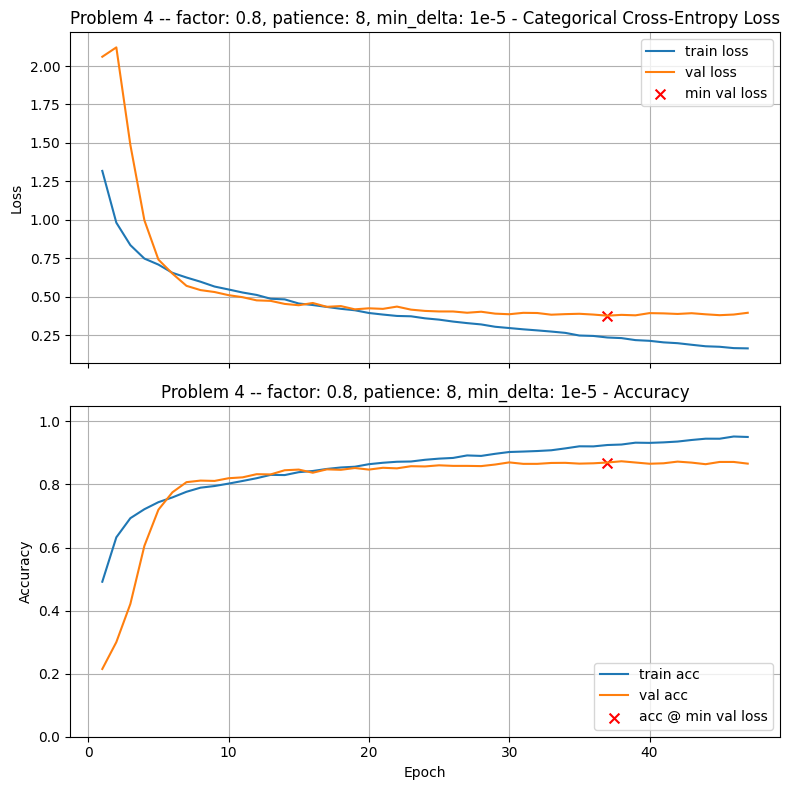

Final Training Loss:            0.1636
Final Training Accuracy:        0.9506
Final Validation Loss:          0.3951
Final Validation Accuracy:      0.8660
Minimum Validation Loss:        0.3762 (Epoch 37)
Validation Accuracy @ Min Loss: 0.8696

Test Loss: 0.3654
Test Accuracy: 0.8733

Validation-Test Gap (accuracy): 0.003722

Execution Time: 00:02:27


In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.8,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=8,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-5,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

# Your code here, add more cells as needed

he = initializers.HeNormal()                                # best initializer for relu

model_reducelr6= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_reducelr6, lr_schedule=1e-4, title="Problem 4 -- factor: 0.8, patience: 8, min_delta: 1e-5", callbacks=[reduce_lr])


Problem 4 -- factor: 0.7, patience: 8, min_delta: 1e-5



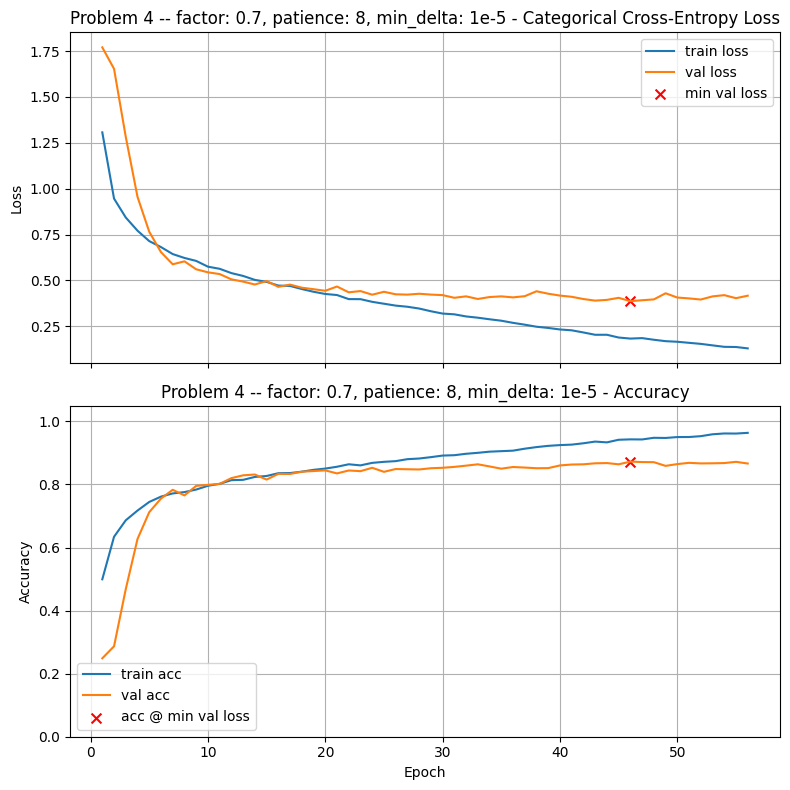

Final Training Loss:            0.1297
Final Training Accuracy:        0.9637
Final Validation Loss:          0.4168
Final Validation Accuracy:      0.8664
Minimum Validation Loss:        0.3869 (Epoch 46)
Validation Accuracy @ Min Loss: 0.8725

Test Loss: 0.3751
Test Accuracy: 0.8720

Validation-Test Gap (accuracy): 0.000462

Execution Time: 00:02:50


In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.7,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=8,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-5,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

# Your code here, add more cells as needed

he = initializers.HeNormal()                                # best initializer for relu

model_reducelr7= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_reducelr7, lr_schedule=1e-4, title="Problem 4 -- factor: 0.7, patience: 8, min_delta: 1e-5", callbacks=[reduce_lr])


Problem 4 -- factor: 0.5, patience: 8, min_delta: 1e-5



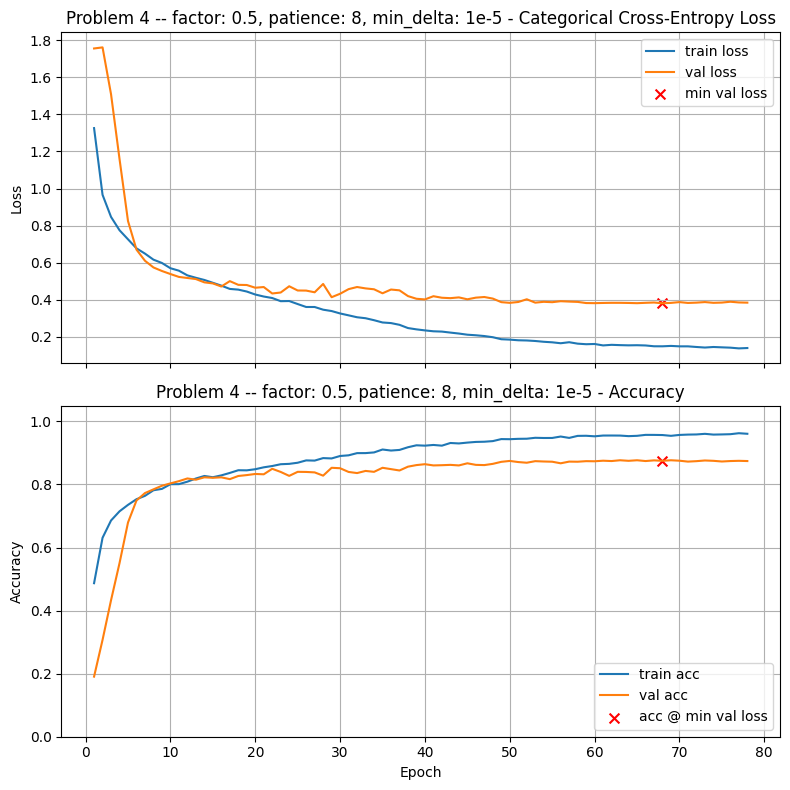

Final Training Loss:            0.1406
Final Training Accuracy:        0.9607
Final Validation Loss:          0.3851
Final Validation Accuracy:      0.8742
Minimum Validation Loss:        0.3816 (Epoch 68)
Validation Accuracy @ Min Loss: 0.8750

Test Loss: 0.3582
Test Accuracy: 0.8787

Validation-Test Gap (accuracy): 0.003711

Execution Time: 00:03:52


In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=8,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-5,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

# Your code here, add more cells as needed

he = initializers.HeNormal()                                # best initializer for relu

model_reducelr8= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_reducelr8, lr_schedule=1e-4, title="Problem 4 -- factor: 0.5, patience: 8, min_delta: 1e-5", callbacks=[reduce_lr])


Problem 4 -- factor: 0.5, patience: 7, min_delta: 1e-5



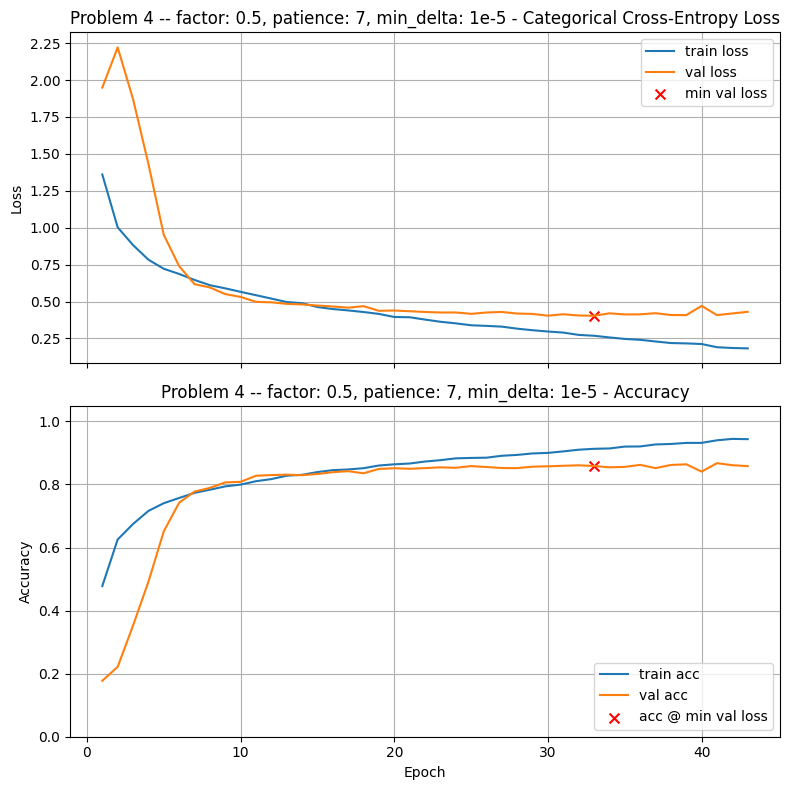

Final Training Loss:            0.1827
Final Training Accuracy:        0.9436
Final Validation Loss:          0.4304
Final Validation Accuracy:      0.8582
Minimum Validation Loss:        0.4035 (Epoch 33)
Validation Accuracy @ Min Loss: 0.8586

Test Loss: 0.3981
Test Accuracy: 0.8613

Validation-Test Gap (accuracy): 0.002765

Execution Time: 00:02:16


In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=7,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-5,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

# Your code here, add more cells as needed

he = initializers.HeNormal()                                # best initializer for relu

model_reducelr9= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_reducelr9, lr_schedule=1e-4, title="Problem 4 -- factor: 0.5, patience: 7, min_delta: 1e-5", callbacks=[reduce_lr])


Problem 4 -- factor: 0.7, patience: 7, min_delta: 1e-5



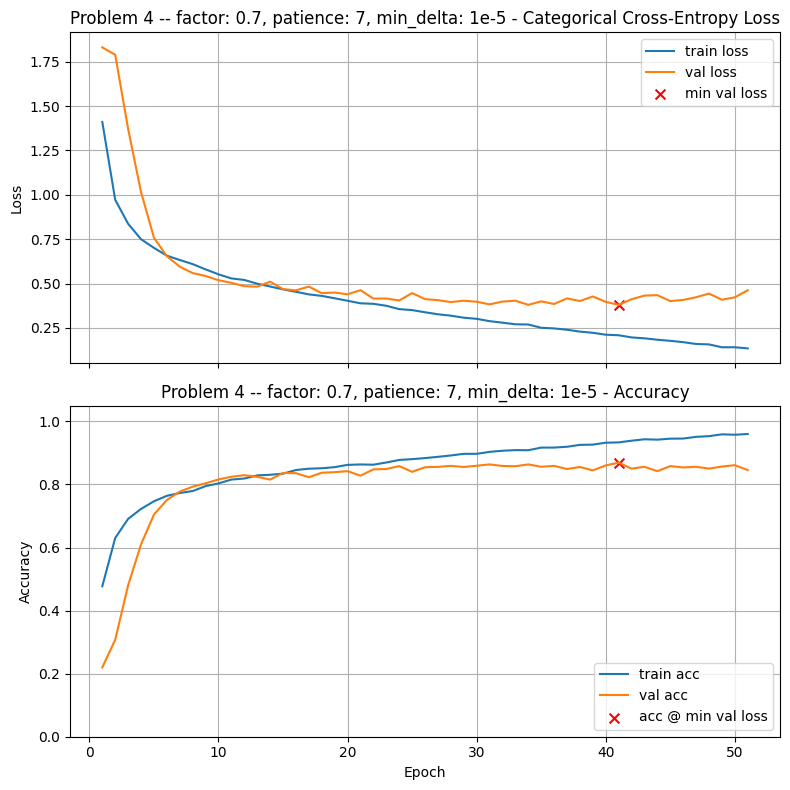

Final Training Loss:            0.1345
Final Training Accuracy:        0.9600
Final Validation Loss:          0.4620
Final Validation Accuracy:      0.8457
Minimum Validation Loss:        0.3797 (Epoch 41)
Validation Accuracy @ Min Loss: 0.8693

Test Loss: 0.3618
Test Accuracy: 0.8687

Validation-Test Gap (accuracy): 0.000589

Execution Time: 00:02:37


In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.7,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=7,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-5,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

# Your code here, add more cells as needed

he = initializers.HeNormal()                                # best initializer for relu

model_reducelr10= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_reducelr10, lr_schedule=1e-4, title="Problem 4 -- factor: 0.7, patience: 7, min_delta: 1e-5", callbacks=[reduce_lr])

In [ ]:
print_results()

Problem 3 -- Tweak 1.1 -- LR: 1e-4      	0.8753	41
Problem 4 -- factor: 0.8, patience: 8   	0.8750	40
Problem 4 -- factor: 0.5, patience: 8, min_delta: 1e-5	0.8750	68
Problem 4 -- factor: 0.7, patience: 8, min_delta: 1e-5	0.8725	46
Problem 4 -- factor: 0.8, patience: 5   	0.8710	44
Problem 4 -- factor: 0.8, patience: 8, min_delta: 1e-5	0.8696	37
Problem 4 -- factor: 0.7, patience: 7, min_delta: 1e-5	0.8693	41
Problem 4 -- factor: 0.7                	0.8689	53
Problem 4 -- factor: 0.5                	0.8685	70
Problem 4 -- factor: 0.3                	0.8636	52
Problem 3 -- Tweak 5.2 -- L2 Reg: 1e-5  	0.8632	10
Problem 3 -- Tweak 1.2 -- LR: 1e-5      	0.8621	226
Problem 4 -- factor: 0.5, patience: 7, min_delta: 1e-5	0.8586	33
Problem 3 -- Tweak 5.1 -- L2 Reg: 1e-4  	0.8564	14
Problem 3 -- Tweak 4 -- Dense: 32       	0.8539	13
Problem 3 -- GAP Baseline               	0.8514	10
Problem 2 -- Tweak 3 -- Adding a Conv2D Layer	0.8272	13
Problem 3 -- Tweak 6 -- Dropout: 0.3    	0.8265	10
Proble

### Graded Questions

In [ ]:
# Set a4a to the factor parameter which gave the best validation accuracy at the point of minimum validation loss

a4a = 0.0             # Replace with your best factor value, or leave at 0.0 if reduce on plateau did not help at all

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4a = {a4a:.2f}')

a4a = 0.00


In [ ]:
# Set a4b to the validation accuracy found by the choice specified in Question a4a (your best model for this problem)

a4b = 0.8753             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4b = {a4b:.4f}')

a4b = 0.8753


## Problem Five: A Very Deep CNN (VGG-16 Style)

 We will now experiment with the VGG-16 design introduced in the Coding Notebook and Video and see how it does on this dataset. For a beautiful description of the model and its significance, see:

        https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/


In this exercise you’ll **only vary the learning rate**. Don’t change any other hyperparameters. Your goal is to observe how LR affects convergence speed, stability, and final validation performance compared to your smaller baselines. This sets up next week’s **transfer learning** with pretrained models.

#### Starting point

* Optimizer: **Adam**
* **Recommended LR to start:** `1e-3`(Adam default)

#### What LR values to try (coarse → fine)

Try a short sweep like:

```
[1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
```

Then, as time allows,  zoom in around the best.

#### How to judge “best”

* Primary: **best validation accuracy at epoch of lowest validation loss**
* Secondary: **time-to-best** (fewer epochs to reach a strong val metric) and **curve shape** (smooth vs. noisy/oscillatory).

#### What symptoms mean

* **LR too high:** training loss spikes or oscillates; val metrics erratic, occasional NaNs/divergence.
* **LR too low:** very slow improvement; long flat regions; never reaches your smaller models’ performance.


**Tip:** Keep LR **constant** during each run (don’t schedule) so you isolate its effect.




VGG-style Large



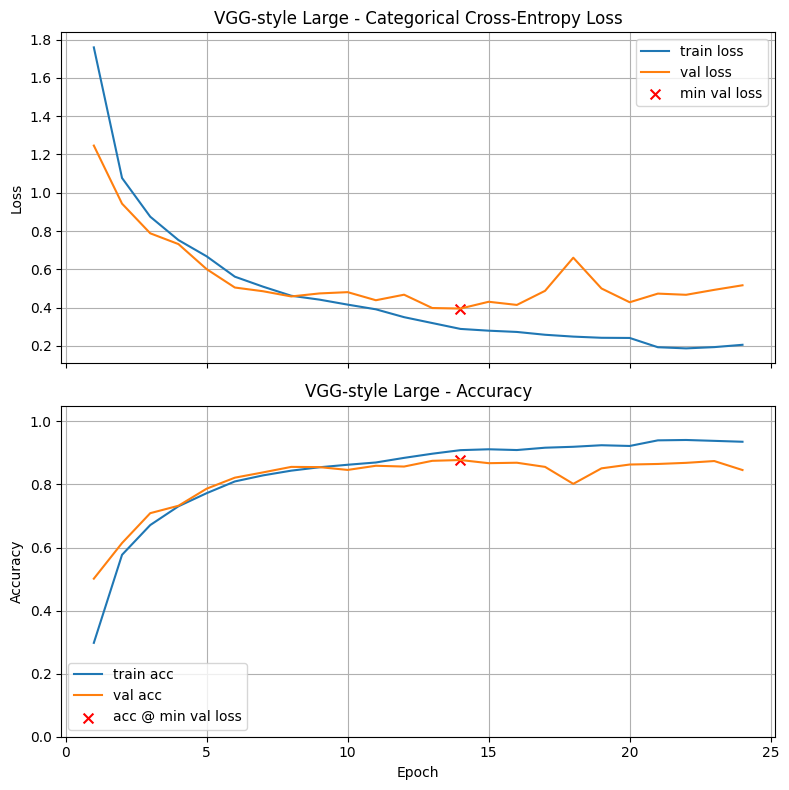

Final Training Loss:            0.2052
Final Training Accuracy:        0.9354
Final Validation Loss:          0.5163
Final Validation Accuracy:      0.8457
Minimum Validation Loss:        0.3947 (Epoch 14)
Validation Accuracy @ Min Loss: 0.8774

Test Loss: 0.4039
Test Accuracy: 0.8763

Validation-Test Gap (accuracy): 0.001116

Execution Time: 00:04:37


In [ ]:
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)   # set to None to disable or tweak the value

model_vgg_16 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Block 1
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 4 (NO MaxPool here -> leaves 3×3×512)
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

    # Global pooling meaningfully summarizes the 3×3 map
    layers.GlobalAveragePooling2D(),   # swap to GlobalMaxPooling2D() to compare

    # Compact head
    layers.Dense(256, activation='relu', kernel_initializer=he,
                 kernel_regularizer=l2reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Uncomment the next line to run

train_and_test(model_vgg_16,lr_schedule=1e-3,title="VGG-style Large")



VGG-style Large -- lr: 1e-2



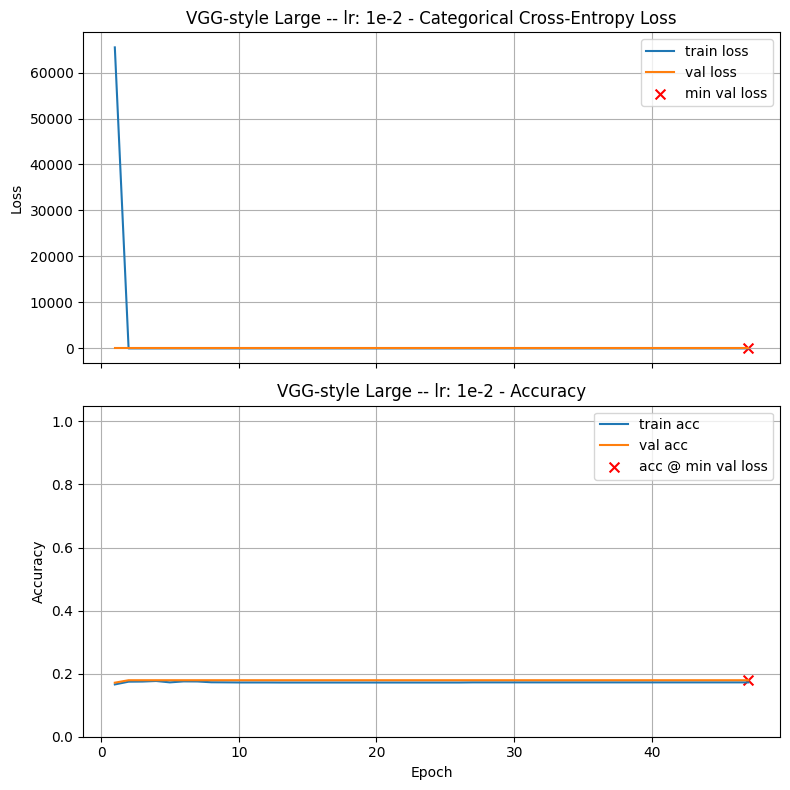

Final Training Loss:            1.8086
Final Training Accuracy:        0.1724
Final Validation Loss:          1.8080
Final Validation Accuracy:      0.1792
Minimum Validation Loss:        1.8080 (Epoch 47)
Validation Accuracy @ Min Loss: 0.1792

Test Loss: 1.8078
Test Accuracy: 0.1750

Validation-Test Gap (accuracy): 0.004195

Execution Time: 00:07:01


In [ ]:
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)   # set to None to disable or tweak the value

model_vgg_16_1 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Block 1
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 4 (NO MaxPool here -> leaves 3×3×512)
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

    # Global pooling meaningfully summarizes the 3×3 map
    layers.GlobalAveragePooling2D(),   # swap to GlobalMaxPooling2D() to compare

    # Compact head
    layers.Dense(256, activation='relu', kernel_initializer=he,
                 kernel_regularizer=l2reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Uncomment the next line to run

train_and_test(model_vgg_16_1,lr_schedule=1e-2,title="VGG-style Large -- lr: 1e-2")


VGG-style Large -- lr: 3e-3



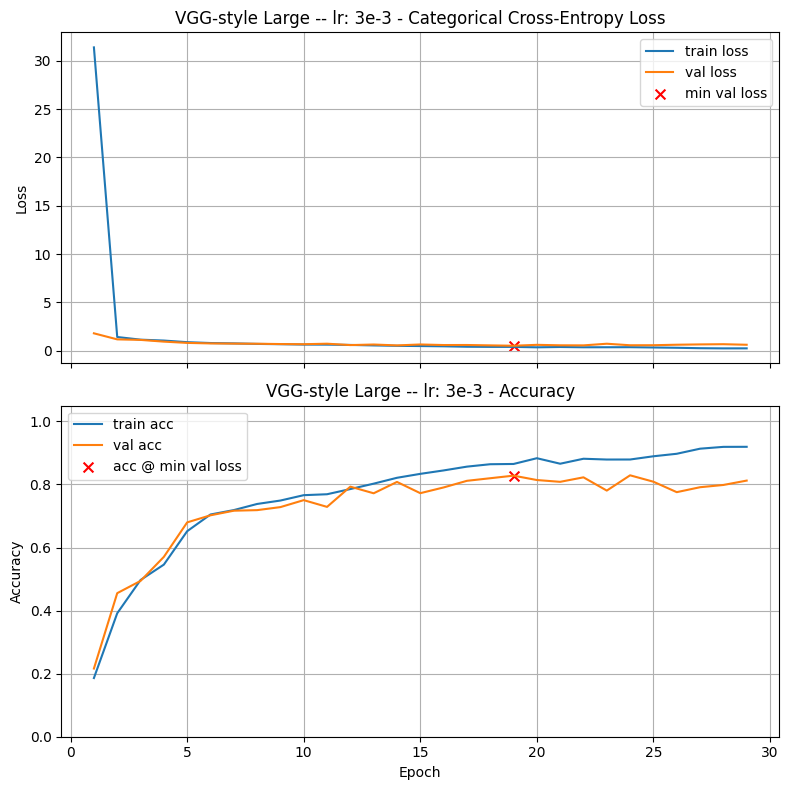

Final Training Loss:            0.2500
Final Training Accuracy:        0.9194
Final Validation Loss:          0.6217
Final Validation Accuracy:      0.8123
Minimum Validation Loss:        0.5201 (Epoch 19)
Validation Accuracy @ Min Loss: 0.8279

Test Loss: 0.4834
Test Accuracy: 0.8320

Validation-Test Gap (accuracy): 0.004070

Execution Time: 00:04:31


In [ ]:
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)   # set to None to disable or tweak the value

model_vgg_16_2 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Block 1
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 4 (NO MaxPool here -> leaves 3×3×512)
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

    # Global pooling meaningfully summarizes the 3×3 map
    layers.GlobalAveragePooling2D(),   # swap to GlobalMaxPooling2D() to compare

    # Compact head
    layers.Dense(256, activation='relu', kernel_initializer=he,
                 kernel_regularizer=l2reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Uncomment the next line to run

train_and_test(model_vgg_16_2,lr_schedule=3e-3,title="VGG-style Large -- lr: 3e-3")


VGG-style Large -- lr: 3e-4



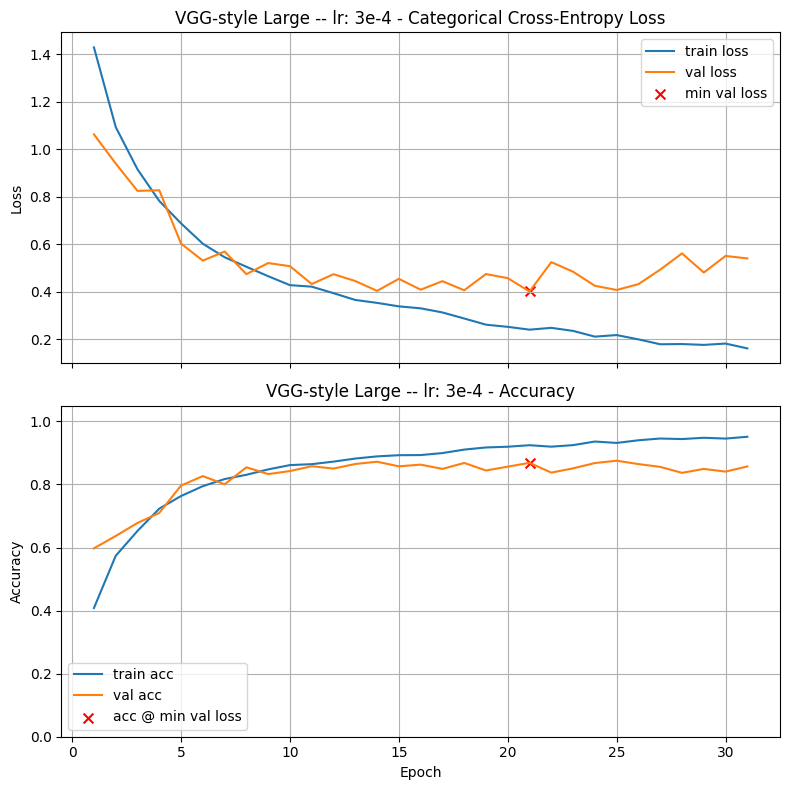

Final Training Loss:            0.1612
Final Training Accuracy:        0.9513
Final Validation Loss:          0.5404
Final Validation Accuracy:      0.8571
Minimum Validation Loss:        0.4011 (Epoch 21)
Validation Accuracy @ Min Loss: 0.8685

Test Loss: 0.4011
Test Accuracy: 0.8740

Validation-Test Gap (accuracy): 0.005457

Execution Time: 00:04:49


In [ ]:
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)   # set to None to disable or tweak the value

model_vgg_16_3 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Block 1
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 4 (NO MaxPool here -> leaves 3×3×512)
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

    # Global pooling meaningfully summarizes the 3×3 map
    layers.GlobalAveragePooling2D(),   # swap to GlobalMaxPooling2D() to compare

    # Compact head
    layers.Dense(256, activation='relu', kernel_initializer=he,
                 kernel_regularizer=l2reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Uncomment the next line to run

train_and_test(model_vgg_16_3,lr_schedule=3e-4,title="VGG-style Large -- lr: 3e-4")


VGG-style Large -- lr: 1e-4



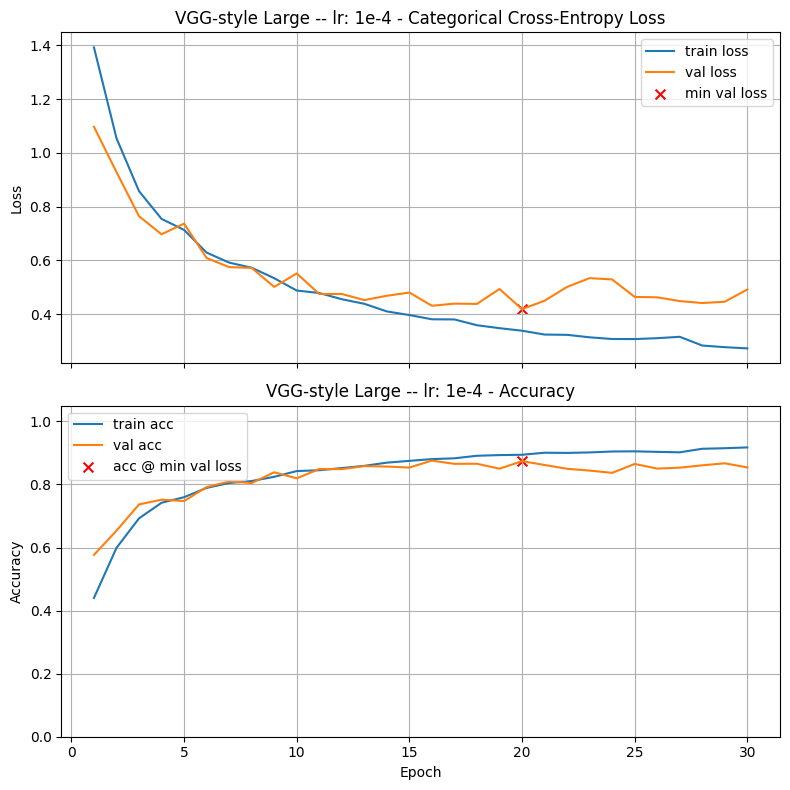

Final Training Loss:            0.2720
Final Training Accuracy:        0.9174
Final Validation Loss:          0.4914
Final Validation Accuracy:      0.8539
Minimum Validation Loss:        0.4182 (Epoch 20)
Validation Accuracy @ Min Loss: 0.8739

Test Loss: 0.3930
Test Accuracy: 0.8713

Validation-Test Gap (accuracy): 0.002553

Execution Time: 00:04:42


In [ ]:
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)   # set to None to disable or tweak the value

model_vgg_16_4 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Block 1
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 4 (NO MaxPool here -> leaves 3×3×512)
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

    # Global pooling meaningfully summarizes the 3×3 map
    layers.GlobalAveragePooling2D(),   # swap to GlobalMaxPooling2D() to compare

    # Compact head
    layers.Dense(256, activation='relu', kernel_initializer=he,
                 kernel_regularizer=l2reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Uncomment the next line to run

train_and_test(model_vgg_16_4,lr_schedule=1e-4,title="VGG-style Large -- lr: 1e-4")


VGG-style Large -- lr: 3e-5



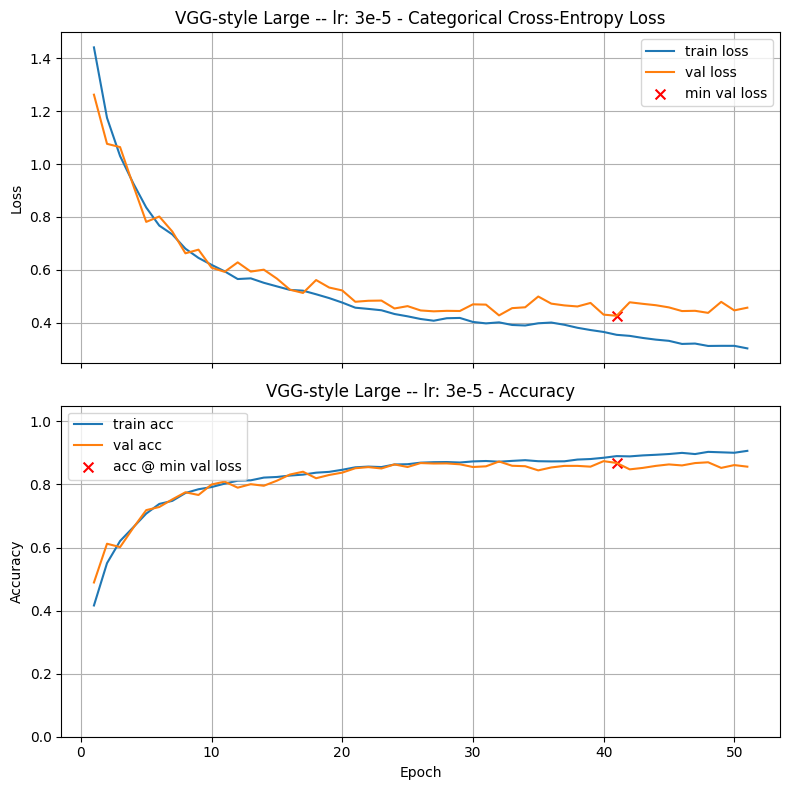

Final Training Loss:            0.3024
Final Training Accuracy:        0.9066
Final Validation Loss:          0.4565
Final Validation Accuracy:      0.8564
Minimum Validation Loss:        0.4259 (Epoch 41)
Validation Accuracy @ Min Loss: 0.8682

Test Loss: 0.4232
Test Accuracy: 0.8690

Validation-Test Gap (accuracy): 0.000813

Execution Time: 00:07:44


In [ ]:
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)   # set to None to disable or tweak the value

model_vgg_16_5 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Block 1
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 4 (NO MaxPool here -> leaves 3×3×512)
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

    # Global pooling meaningfully summarizes the 3×3 map
    layers.GlobalAveragePooling2D(),   # swap to GlobalMaxPooling2D() to compare

    # Compact head
    layers.Dense(256, activation='relu', kernel_initializer=he,
                 kernel_regularizer=l2reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Uncomment the next line to run

train_and_test(model_vgg_16_5,lr_schedule=3e-5,title="VGG-style Large -- lr: 3e-5")


VGG-style Large -- lr: 1e-5



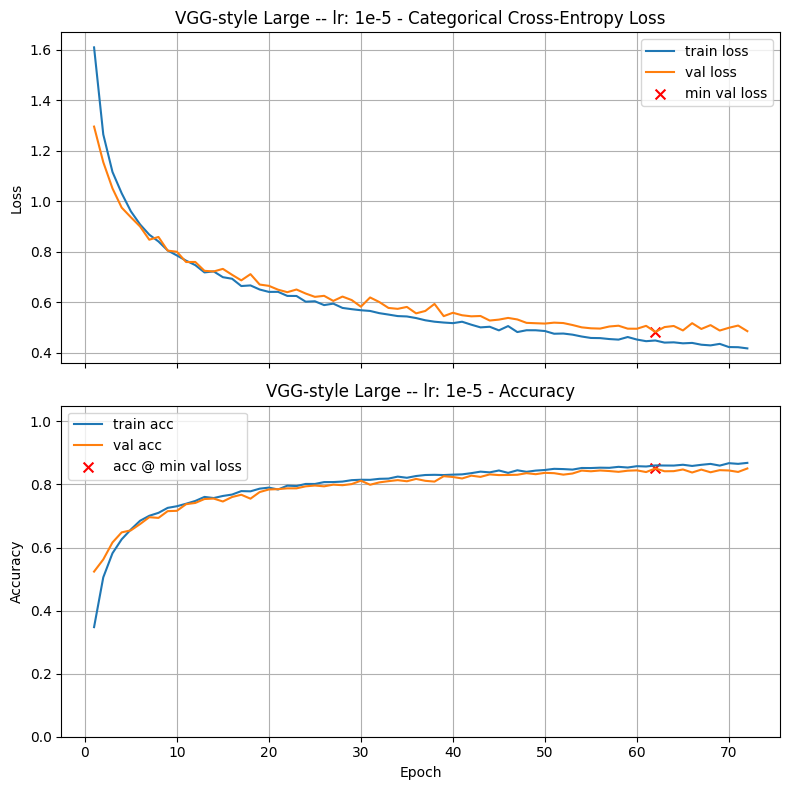

Final Training Loss:            0.4163
Final Training Accuracy:        0.8684
Final Validation Loss:          0.4845
Final Validation Accuracy:      0.8507
Minimum Validation Loss:        0.4816 (Epoch 62)
Validation Accuracy @ Min Loss: 0.8507

Test Loss: 0.4713
Test Accuracy: 0.8513

Validation-Test Gap (accuracy): 0.000603

Execution Time: 00:10:46


In [ ]:
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)   # set to None to disable or tweak the value

model_vgg_16_6 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Block 1
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 4 (NO MaxPool here -> leaves 3×3×512)
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

    # Global pooling meaningfully summarizes the 3×3 map
    layers.GlobalAveragePooling2D(),   # swap to GlobalMaxPooling2D() to compare

    # Compact head
    layers.Dense(256, activation='relu', kernel_initializer=he,
                 kernel_regularizer=l2reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Uncomment the next line to run

train_and_test(model_vgg_16_6,lr_schedule=1e-5,title="VGG-style Large -- lr: 1e-5")

In [ ]:
print_results()

VGG-style Large                         	0.8774	14
Problem 3 -- Tweak 1.1 -- LR: 1e-4      	0.8753	41
Problem 4 -- factor: 0.8, patience: 8   	0.8750	40
Problem 4 -- factor: 0.5, patience: 8, min_delta: 1e-5	0.8750	68
VGG-style Large -- lr: 1e-4             	0.8739	20
Problem 4 -- factor: 0.7, patience: 8, min_delta: 1e-5	0.8725	46
Problem 4 -- factor: 0.8, patience: 5   	0.8710	44
Problem 4 -- factor: 0.8, patience: 8, min_delta: 1e-5	0.8696	37
Problem 4 -- factor: 0.7, patience: 7, min_delta: 1e-5	0.8693	41
Problem 4 -- factor: 0.7                	0.8689	53
Problem 4 -- factor: 0.5                	0.8685	70
VGG-style Large -- lr: 3e-4             	0.8685	21
VGG-style Large -- lr: 3e-5             	0.8682	41
Problem 4 -- factor: 0.3                	0.8636	52
Problem 3 -- Tweak 5.2 -- L2 Reg: 1e-5  	0.8632	10
Problem 3 -- Tweak 1.2 -- LR: 1e-5      	0.8621	226
Problem 4 -- factor: 0.5, patience: 7, min_delta: 1e-5	0.8586	33
Problem 3 -- Tweak 5.1 -- L2 Reg: 1e-4  	0.8564	14
Problem 3 -

### Graded Questions

In [ ]:
# Set a5a to the learning rate which gave the best validation accuracy at the point of minimum validation loss

a5a = 1e-3             # Replace with your best learning rate

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5a = {a5a:.8f}')

a5a = 0.00100000


In [ ]:
# Set a5b to the validation accuracy found by the choice specified in Question a5a (your best model for this problem)

a5b = 0.8774              # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5b = {a5b:.4f}')

a5b = 0.8774


## All Results

This will print out the results from all experiments, with titles as keys. I use this all the time to keep track of experiments!

In [ ]:
print_results()

VGG-style Large                         	0.8774	14
Problem 3 -- Tweak 1.1 -- LR: 1e-4      	0.8753	41
Problem 4 -- factor: 0.8, patience: 8   	0.8750	40
Problem 4 -- factor: 0.5, patience: 8, min_delta: 1e-5	0.8750	68
VGG-style Large -- lr: 1e-4             	0.8739	20
Problem 4 -- factor: 0.7, patience: 8, min_delta: 1e-5	0.8725	46
Problem 4 -- factor: 0.8, patience: 5   	0.8710	44
Problem 4 -- factor: 0.8, patience: 8, min_delta: 1e-5	0.8696	37
Problem 4 -- factor: 0.7, patience: 7, min_delta: 1e-5	0.8693	41
Problem 4 -- factor: 0.7                	0.8689	53
Problem 4 -- factor: 0.5                	0.8685	70
VGG-style Large -- lr: 3e-4             	0.8685	21
VGG-style Large -- lr: 3e-5             	0.8682	41
Problem 4 -- factor: 0.3                	0.8636	52
Problem 3 -- Tweak 5.2 -- L2 Reg: 1e-5  	0.8632	10
Problem 3 -- Tweak 1.2 -- LR: 1e-5      	0.8621	226
Problem 4 -- factor: 0.5, patience: 7, min_delta: 1e-5	0.8586	33
Problem 3 -- Tweak 5.1 -- L2 Reg: 1e-4  	0.8564	14
Problem 3 -